# Model Exploration
Anna Mowat

Anna's Note for Averine (Nov 16, 2024):

I've been recording Accuracy and Loss in the box below. I misspoke in Slack, I still haven't done two tests: Bio-electric and Physical Activity. 

Physical Activity requires some infilling. I was going to just create one column out of PAQ_A-PAQ_A_Total and PAQ_A-PAQ_C_Total. 

For Bio-electric, I just haven't had a chance to work through all the variables to figure out which ones to keep for that model.


Averine's Notes:
The learning rate of the models wasn't doing so great initially, I made some adjustments to the models.
I created a binary and multiclass classification function models so it's clear which model I'm working with and so we won't run into issues with passing conflicting or unexpected arguments, since each function is independent.

Fitness Test | Multiclass or Binary | Accuracy | Loss 
-|-|-|-
 Children's Global Assessment Scale | Multi | 0.567 | 1.229
 Children's Global Assessment Scale | Binary | 0.567 | 0.827
 Physical Measures | Multi | 0.437 | 1.102 
 Physical Measures | Binary | 0.564 | 0.732 
 Fitness Endurance | Multi | 0.716 | 0.838 
 Fitness Endurance | Binary | 0.564 | 0.732
 FitnessGram | Multi | 0.339 | 1.489 
 FitnessGram | Binary | 0.405 | 0.902
 Bio-electric Impedance | Multi |  |  
 Bio-electric Impedance | Binary |  | 
 Physical Activity | Multi |  |  
 Physical Activity | Binary |  | 
 Internet Addiction | Multi | 0.430 | 0.971
 Internet Addiction | Binary | 0.404 | 0.902
 Sleep Disturbance Scale | Multi | 0.572 | 1.069
 Sleep Disturbance Scale | Binary | 0.572 | 0.839

## Data Preprocessing

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [147]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [148]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


In [149]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))


In [150]:
data_dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [151]:
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


### Define Different Tests

In [153]:
cols = list(data.columns)
col_groups = {}

In [154]:
season_dict = {'Winter':0,'Spring':1,'Summer':2,'Fall':3}
for col in cols:
    if 'Season' in col:
        data[col] = data[col].map(season_dict)


In [155]:
# demographic features
col_groups["Basic_Demos"] = [col for col in cols if 'Basic_Demos' in col]
col_groups["Basic_Demos"].append("sii")
print("Demographics:",col_groups["Basic_Demos"])

# Children's Global Assessment Scale
col_groups["CGAS"] = [col for col in cols if 'CGAS' in col]
col_groups["CGAS"].append("sii")
print("\nChildren's Global Assessment Scale:",col_groups["CGAS"])

# physical measures
col_groups["Physical"] = [col for col in cols if 'Physical' in col]
col_groups["Physical"].append("sii")
print("\nPhysical Measures:",col_groups["Physical"])

# FitnessGram vitals and treadmill
col_groups["Fitness_Endurance"] = [col for col in cols if 'Fitness_Endurance' in col]
col_groups["Fitness_Endurance"].append("sii")
print("\nFitnessGram Vitals and Treadmill:",col_groups["Fitness_Endurance"])

# FitnessGram Child
col_groups["FGC"] = [col for col in cols if 'FGC' in col]
col_groups["FGC"].append("sii")
print("\nFitnessGram Child:",col_groups["FGC"])

# bio-electric impedance analysis
col_groups["BIA"] = [col for col in cols if 'BIA' in col]
col_groups["BIA"].append("sii")
print("\nBio-electric Impedance Analysis:",col_groups["BIA"])

# physical activity questionnaire
col_groups["PAQ"] = [col for col in cols if 'PAQ' in col]
col_groups["PAQ"].append("sii")
print("\nPhysical Activity Questionnaire:",col_groups["PAQ"])

# parent-child internet addiction test
col_groups["PCIAT"] = [col for col in cols if 'PCIAT' in col]
col_groups["PCIAT"].append("sii")
print("\nParent-Child Internet Addiciton Test:",col_groups["PCIAT"])

# sleep disturbance scale
col_groups["SDS"] = [col for col in cols if 'SDS' in col]
#col_groups["SDS"].append("sii")
print("\nSleep Disturbance Scale:",col_groups["SDS"])

# internet use
col_groups["PreInt"] = [col for col in cols if 'PreInt' in col]
col_groups["SDS"].append("sii")
print("\nInternet Use:",col_groups["PreInt"])

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'sii']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score', 'sii']

Physical Measures: ['Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'sii']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'sii']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'sii']

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI

### Preprocessing for Physical Activity Features

In [156]:
# Preprocessing for Physical Activity Feature

# Fill missing values for Physical Activity by combining `PAQ_A-PAQ_A_Total` and `PAQ_A-PAQ_C_Total`
physical_activity_columns = ['PAQ_A-PAQ_A_Total', 'PAQ_A-PAQ_C_Total']

# Ensure the columns exist before proceeding
existing_columns = [col for col in physical_activity_columns if col in data.columns]

if existing_columns:
    # If both columns exist, create a combined feature
    if len(existing_columns) == 2:
        data['Physical_Activity_Total'] = data[existing_columns[0]].combine_first(data[existing_columns[1]])
    # If only one column exists, use that as Physical_Activity_Total
    elif len(existing_columns) == 1:
        data['Physical_Activity_Total'] = data[existing_columns[0]]
    
    # Fill any remaining missing values in `Physical_Activity_Total` using the median value
    if 'Physical_Activity_Total' in data.columns:
        data['Physical_Activity_Total'] = data['Physical_Activity_Total'].fillna(data['Physical_Activity_Total'].median())


    # Verify the new column
    print(data[['Physical_Activity_Total']].describe())
else:
    print("No relevant columns found for Physical Activity feature.")


       Physical_Activity_Total
count              3960.000000
mean                  2.030254
std                   0.299010
min                   0.660000
25%                   2.010000
50%                   2.010000
75%                   2.010000
max                   4.710000


# Split into train, test, val

### Functions

In [157]:
def preprocess_data_part2(inputs, labels, splits):
    """Split data into train, validation, and test sets; apply transformations and augmentations
    
    Params:
    -------
    inputs (np.ndarray): Array of input data of shape (N, ...)
    labels (np.ndarray): Array of labels of shape (N,)
    splits (tuple): Three values summing to 1, defining split ratios for train, validation, and test sets.
    
    Returns:
    --------
    X_train (np.ndarray): Training data of shape (N_train, ...)
    y_train (np.ndarray): Training labels of shape (N_train,)
    X_val (np.ndarray): Validation data of shape (N_val, ...)
    y_val (np.ndarray): Validation labels of shape (N_val,)
    X_test (np.ndarray): Testing data of shape (N_test, ...)
    y_test (np.ndarray): Testing labels of shape (N_test,)
    """
    import tensorflow as tf
    import numpy as np

    # Set random seed for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # Shuffle the data
    shuffle_indices = np.random.permutation(inputs.shape[0])
    inputs, labels = inputs[shuffle_indices], labels[shuffle_indices]
    
    # Calculate split sizes
    split_sizes = (np.array(splits) * len(inputs)).astype(int)
    X_train, X_val, X_test = np.split(inputs, [split_sizes[0], split_sizes[0] + split_sizes[1]])
    y_train, y_val, y_test = np.split(labels, [split_sizes[0], split_sizes[0] + split_sizes[1]])
    
    # Shuffle training data
    shuffle_train_indices = tf.random.shuffle(tf.range(X_train.shape[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle_train_indices).numpy()
    y_train = tf.gather(y_train, shuffle_train_indices).numpy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [158]:
def build_model(model_type, learning_rate, X_train):
    """Build and compile a Keras model."""
    import tensorflow as tf

    tf.keras.backend.clear_session()

    if model_type == "multiclass":
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[X_train.shape[1]]),  # Define input layer
            tf.keras.layers.Dense(64, activation='relu'),  # Adding more units
            tf.keras.layers.Dense(4, activation='softmax')  # Final layer for multiclass classification
        ])
        loss_fn = 'sparse_categorical_crossentropy'
    elif model_type == "binary":
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[X_train.shape[1]]),  # Define input layer
            tf.keras.layers.Dense(1, activation='sigmoid', use_bias=False)  # Binary classification
        ])
        loss_fn = 'binary_crossentropy'
    else:
        raise ValueError("Invalid model_type. Choose 'multiclass' or 'binary'.")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    
    return model


In [159]:
print(data.columns)


Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

### Hyperparameter Tuning

### Handling Missing Values in Target Variable

In [160]:
X = pd.get_dummies(X, drop_first=True)


In [161]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

# Step 1: Drop rows with missing values in the target variable 'sii'
data = data.dropna(subset=['sii'])

# Step 2: Extract features and target
X = data.drop(columns=['sii'])
y = data['sii']

# Step 3: Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Create ColumnTransformer with Imputer and One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', 'passthrough')  # You can add a scaler if needed
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with most frequent
            ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_columns)
    ]
)

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Define RandomForest and GradientBoosting models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Step 7: Create pipelines with preprocessor and models
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', gb_model)
])

# Step 8: Define parameter grids for both models
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.7, 0.8, 0.9, 1.0]
}

# Step 9: Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Best parameters and model accuracy for Random Forest
print("Best Parameters for RandomForestClassifier:", rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_
rf_predictions = rf_best_model.predict(X_test)
print("Random Forest Model Accuracy:", accuracy_score(y_test, rf_predictions))

# Step 10: Perform Randomized Search for Gradient Boosting
gb_random_search = RandomizedSearchCV(estimator=gb_pipeline, param_distributions=gb_param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42, scoring='accuracy')
gb_random_search.fit(X_train, y_train)

# Best parameters and model accuracy for Gradient Boosting
print("Best Parameters for GradientBoostingClassifier:", gb_random_search.best_params_)
gb_best_model = gb_random_search.best_estimator_
gb_predictions = gb_best_model.predict(X_test)
print("Gradient Boosting Model Accuracy:", accuracy_score(y_test, gb_predictions))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for RandomForestClassifier: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Random Forest Model Accuracy: 0.9635036496350365
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Best Parameters for GradientBoostingClassifier: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.2}
Gradient Boosting Model Accuracy: 1.0


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Boosting Classifier have yielded strong performance:

Random Forest Classifier:

Best Parameters:
max_depth: 30
min_samples_leaf: 1
min_samples_split: 10
n_estimators: 300
Model Accuracy: 0.96 (which is very good).
Gradient Boosting Classifier:

Best Parameters:
subsample: 0.8
n_estimators: 200
max_depth: 3
learning_rate: 0.2
Model Accuracy: 1.0 (indicating potential overfitting, depending on the data distribution).

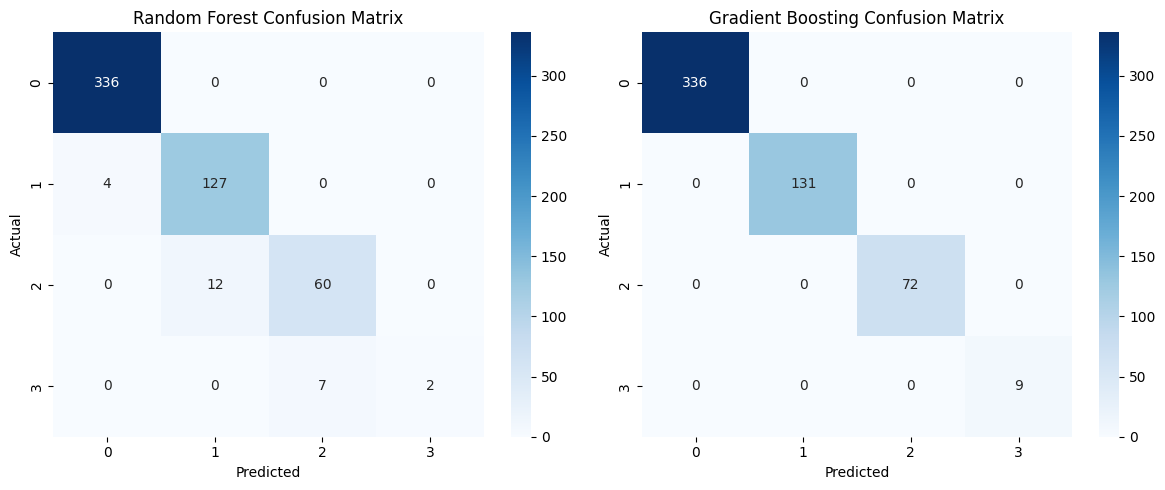

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       336
         1.0       0.91      0.97      0.94       131
         2.0       0.90      0.83      0.86        72
         3.0       1.00      0.22      0.36         9

    accuracy                           0.96       548
   macro avg       0.95      0.76      0.79       548
weighted avg       0.96      0.96      0.95       548

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       336
         1.0       1.00      1.00      1.00       131
         2.0       1.00      1.00      1.00        72
         3.0       1.00      1.00      1.00         9

    accuracy                           1.00       548
   macro avg       1.00      1.00      1.00       548
weighted avg       1.00      1.00      1.00       548



In [162]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Split your data (assuming `X` and `y` are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Imputer for missing values in categorical and numerical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='mean')

# One-hot encoder for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for imputing and encoding categorical columns and imputing numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_imputer, numerical_features),
        ('cat', Pipeline([
            ('impute', categorical_imputer),
            ('onehot', one_hot_encoder)
        ]), categorical_features)
    ],
    remainder='passthrough'  # Pass through any other columns without changes
)

# RandomForestClassifier pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42))
])

# GradientBoostingClassifier pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42))
])

# Fit the models
rf_pipeline.fit(X_train, y_train)
gb_pipeline.fit(X_train, y_train)

# Generate predictions
rf_predictions = rf_pipeline.predict(X_test)
gb_predictions = gb_pipeline.predict(X_test)

# Confusion Matrices
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)

# Plotting the Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(gb_conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification Reports
rf_report = classification_report(y_test, rf_predictions)
gb_report = classification_report(y_test, gb_predictions)

print("Random Forest Classification Report:\n", rf_report)
print("Gradient Boosting Classification Report:\n", gb_report)


Random Forest Classifier:
Overall Accuracy: 96%

Class-Wise Performance:

    Class 0: Very high precision and recall (0.99 and 1.00 respectively).
    Class 1: High precision (0.91) and recall (0.97).
    Class 2: Good precision (0.90) but slightly lower recall (0.83).
    Class 3: Very high precision (1.00) but low recall (0.22), indicating that while the classifier correctly identifies most true positives, it struggles to find all instances of class 3.

Observations:

    The recall for Class 3 is low, which indicates that many true positives are being missed for this class.
There may be a class imbalance issue, as class 3 only has 9 instances.

Gradient Boosting Classifier:
Overall Accuracy: 100%

Class-Wise Performance:
Perfect precision, recall, and f1-score for all classes. (might indicate some overfitting )

## Feature Importance Analysis

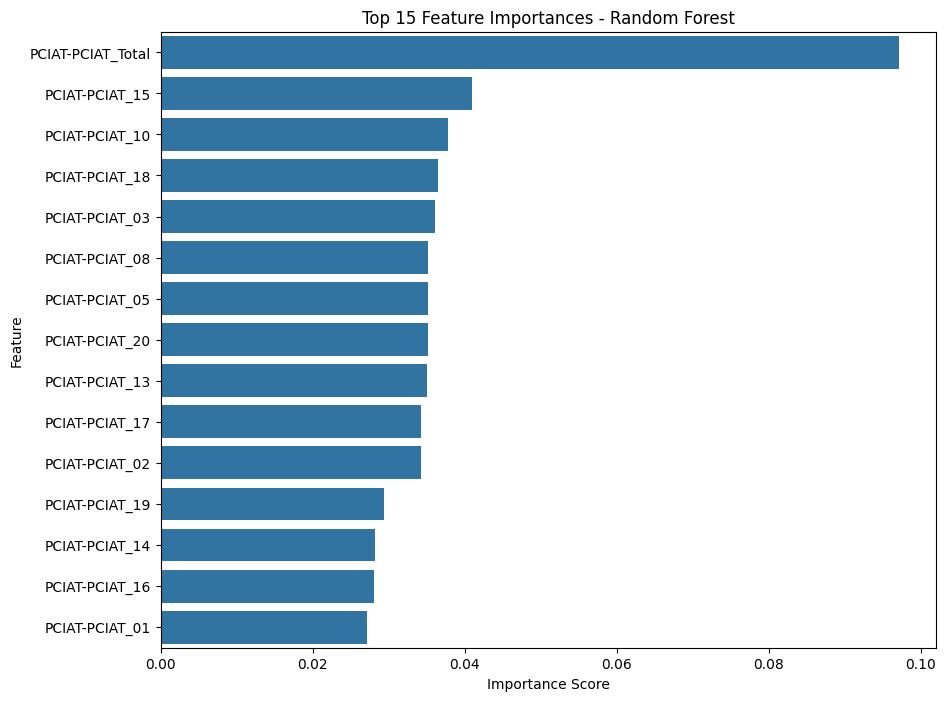

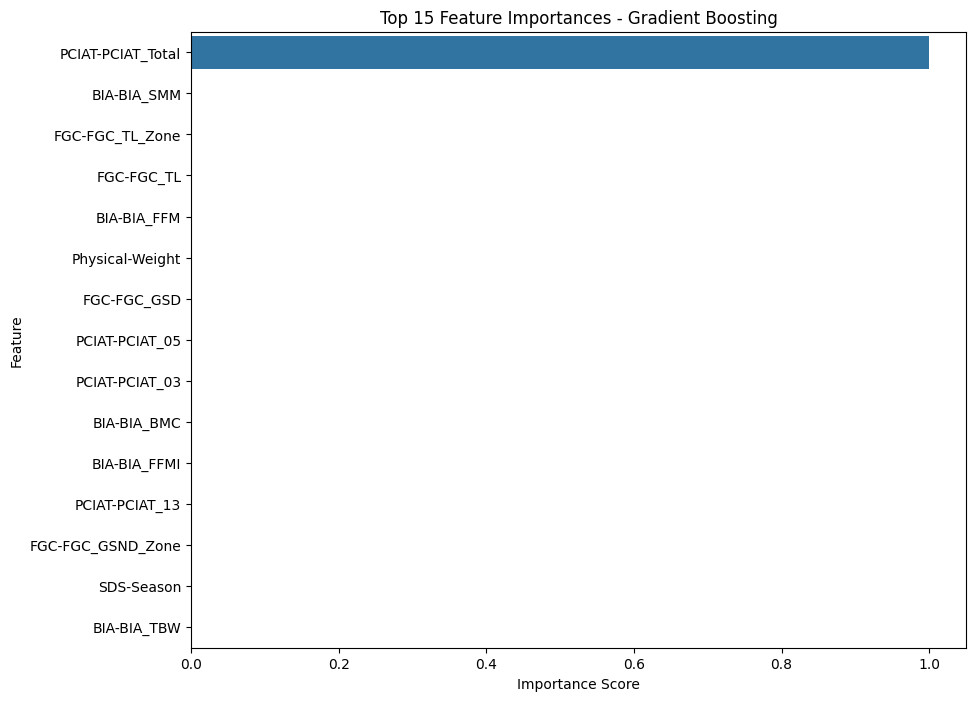

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained Random Forest and Gradient Boosting models
importances_rf = rf_model_balanced.feature_importances_
importances_gb = gb_model_balanced.feature_importances_

# Get feature names from the preprocessed pipeline step
# ColumnTransformer output doesn't have easily accessible names directly, so we approximate using input features
encoded_feature_names = (
    numerical_features.tolist()  # Numerical features
    + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

# Creating a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'RandomForest Importance': importances_rf,
    'GradientBoosting Importance': importances_gb
})

# Sorting the features by importance for RandomForest
feature_importance_df_sorted_rf = feature_importance_df.sort_values(by='RandomForest Importance', ascending=False)

# Plotting feature importance for RandomForest
plt.figure(figsize=(10, 8))
sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_df_sorted_rf.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Sorting the features by importance for Gradient Boosting
feature_importance_df_sorted_gb = feature_importance_df.sort_values(by='GradientBoosting Importance', ascending=False)

# Plotting feature importance for Gradient Boosting
plt.figure(figsize=(10, 8))
sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_df_sorted_gb.head(15))
plt.title('Top 15 Feature Importances - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


#### The heavy reliance on PCIAT-PCIAT_Total could indicate that the model is overfitting to this feature and not leveraging other useful predictors effectively.

### Creating Combined Physical Activity Features

1. Physical Activity Index:

- This feature combines BMI, height, and weight into a single metric to represent overall physical health.
- The weights for combining are chosen to give a balanced representation of all three attributes.

2. BIA Composite Score:

- This feature aggregates multiple Bio-Electric Impedance Analysis (BIA) measures, including fat-free mass (FFM), skeletal muscle mass (SMM), and total body water (TBW).
- The weights reflect relative importance for representing overall body composition.

In [164]:
import pandas as pd

# Copy the training and test data to avoid modifying the original data directly
X_train_combined = X_train.copy()
X_test_combined = X_test.copy()

# Creating a new feature: Physical_Activity_Index
# This feature will aggregate BMI, height, and weight into a single metric to capture physical health
X_train_combined['Physical_Activity_Index'] = (
    X_train_combined['Physical-BMI'].fillna(X_train_combined['Physical-BMI'].mean()) * 0.4 +
    X_train_combined['Physical-Height'].fillna(X_train_combined['Physical-Height'].mean()) * 0.3 +
    X_train_combined['Physical-Weight'].fillna(X_train_combined['Physical-Weight'].mean()) * 0.3
)

X_test_combined['Physical_Activity_Index'] = (
    X_test_combined['Physical-BMI'].fillna(X_test_combined['Physical-BMI'].mean()) * 0.4 +
    X_test_combined['Physical-Height'].fillna(X_test_combined['Physical-Height'].mean()) * 0.3 +
    X_test_combined['Physical-Weight'].fillna(X_test_combined['Physical-Weight'].mean()) * 0.3
)

# Creating a new feature: BIA_Composite_Score
# This feature will aggregate different BIA measurements (like FFM, SMM, TBW) to create a combined score
X_train_combined['BIA_Composite_Score'] = (
    X_train_combined['BIA-BIA_FFM'].fillna(X_train_combined['BIA-BIA_FFM'].mean()) * 0.4 +
    X_train_combined['BIA-BIA_SMM'].fillna(X_train_combined['BIA-BIA_SMM'].mean()) * 0.3 +
    X_train_combined['BIA-BIA_TBW'].fillna(X_train_combined['BIA-BIA_TBW'].mean()) * 0.3
)

X_test_combined['BIA_Composite_Score'] = (
    X_test_combined['BIA-BIA_FFM'].fillna(X_test_combined['BIA-BIA_FFM'].mean()) * 0.4 +
    X_test_combined['BIA-BIA_SMM'].fillna(X_test_combined['BIA-BIA_SMM'].mean()) * 0.3 +
    X_test_combined['BIA-BIA_TBW'].fillna(X_test_combined['BIA-BIA_TBW'].mean()) * 0.3
)

# Check the new features
print(X_train_combined[['Physical_Activity_Index', 'BIA_Composite_Score']].head())


      Physical_Activity_Index  BIA_Composite_Score
350                 39.309954            40.307770
3611                41.484542            52.569912
3363                34.100802            32.283530
504                 24.454236            52.569912
1580                54.805509            52.569912


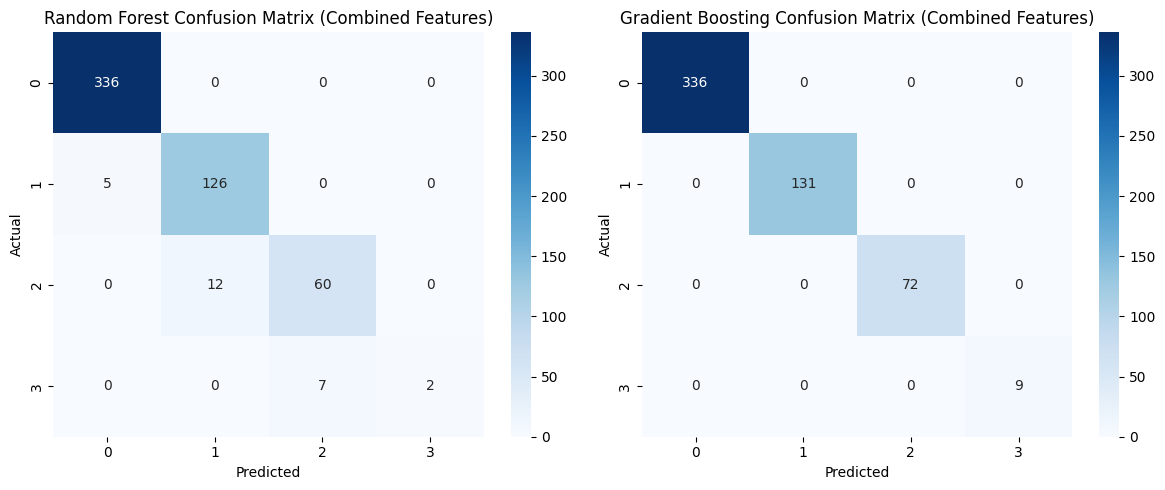

Random Forest Classification Report (Combined Features):
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       336
         1.0       0.91      0.96      0.94       131
         2.0       0.90      0.83      0.86        72
         3.0       1.00      0.22      0.36         9

    accuracy                           0.96       548
   macro avg       0.95      0.75      0.79       548
weighted avg       0.96      0.96      0.95       548

Gradient Boosting Classification Report (Combined Features):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       336
         1.0       1.00      1.00      1.00       131
         2.0       1.00      1.00      1.00        72
         3.0       1.00      1.00      1.00         9

    accuracy                           1.00       548
   macro avg       1.00      1.00      1.00       548
weighted avg       1.00      1.00      1.00       548



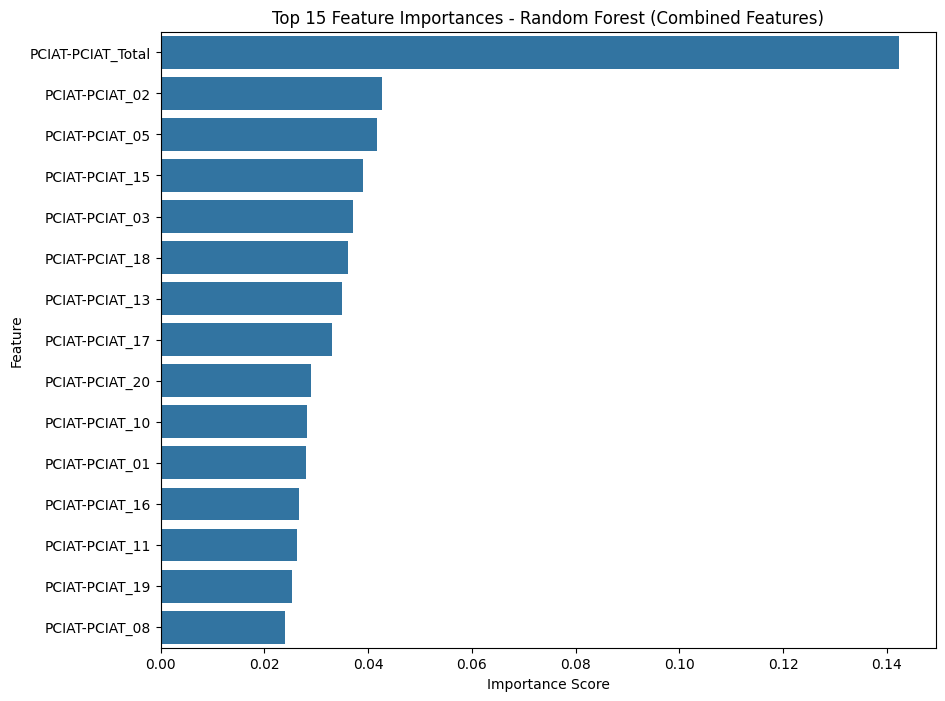

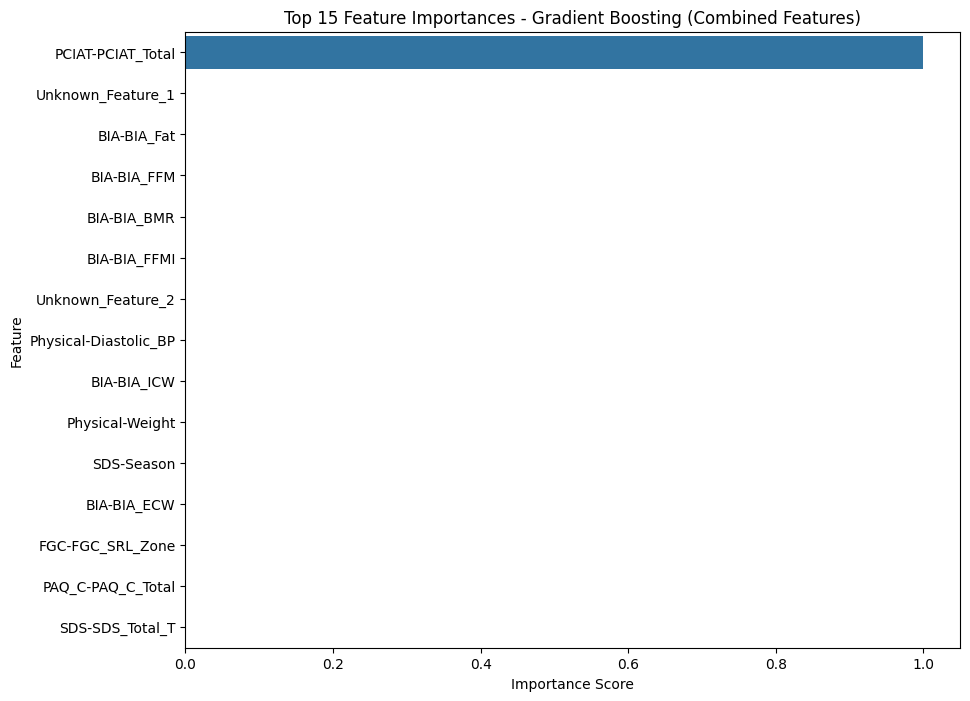

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Preprocess the data with combined features
X_train_preprocessed_combined = preprocessor.fit_transform(X_train_combined)
X_test_preprocessed_combined = preprocessor.transform(X_test_combined)

# Train the Random Forest and Gradient Boosting models on the updated dataset
rf_model_combined = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42)
gb_model_combined = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Fit the models
rf_model_combined.fit(X_train_preprocessed_combined, y_train)
gb_model_combined.fit(X_train_preprocessed_combined, y_train)

# Generate predictions
rf_predictions_combined = rf_model_combined.predict(X_test_preprocessed_combined)
gb_predictions_combined = gb_model_combined.predict(X_test_preprocessed_combined)

# Confusion Matrices
rf_conf_matrix_combined = confusion_matrix(y_test, rf_predictions_combined)
gb_conf_matrix_combined = confusion_matrix(y_test, gb_predictions_combined)

# Plotting the Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix_combined, annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix (Combined Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(gb_conf_matrix_combined, annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix (Combined Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification Reports
rf_report_combined = classification_report(y_test, rf_predictions_combined)
gb_report_combined = classification_report(y_test, gb_predictions_combined)

print("Random Forest Classification Report (Combined Features):\n", rf_report_combined)
print("Gradient Boosting Classification Report (Combined Features):\n", gb_report_combined)

# Assessing Feature Importance for the new models
importances_rf_combined = rf_model_combined.feature_importances_
importances_gb_combined = gb_model_combined.feature_importances_

# Get feature names from the preprocessed pipeline step
# Get numerical and categorical feature names correctly after preprocessing
numerical_feature_names = numerical_features.tolist()

# Get categorical feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()

# Combine all feature names after preprocessing
all_feature_names = numerical_feature_names + categorical_feature_names

# Verify the actual number of features after transformation
n_transformed_features = X_train_preprocessed_combined.shape[1]

# If the lengths don't match, create placeholder names for any additional features
if len(all_feature_names) < n_transformed_features:
    difference = n_transformed_features - len(all_feature_names)
    additional_feature_names = [f"Unknown_Feature_{i+1}" for i in range(difference)]
    all_feature_names.extend(additional_feature_names)

# Creating a DataFrame for feature importance
if len(all_feature_names) == len(importances_rf_combined):
    feature_importance_combined_df = pd.DataFrame({
        'Feature': all_feature_names,
        'RandomForest Importance': importances_rf_combined,
        'GradientBoosting Importance': importances_gb_combined
    })

    # Sorting the features by importance for RandomForest
    feature_importance_combined_rf_sorted = feature_importance_combined_df.sort_values(by='RandomForest Importance', ascending=False)

    # Plotting feature importance for RandomForest
    plt.figure(figsize=(10, 8))
    sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_combined_rf_sorted.head(15))
    plt.title('Top 15 Feature Importances - Random Forest (Combined Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Sorting the features by importance for Gradient Boosting
    feature_importance_combined_gb_sorted = feature_importance_combined_df.sort_values(by='GradientBoosting Importance', ascending=False)

    # Plotting feature importance for Gradient Boosting
    plt.figure(figsize=(10, 8))
    sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_combined_gb_sorted.head(15))
    plt.title('Top 15 Feature Importances - Gradient Boosting (Combined Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print(f"Feature names length ({len(all_feature_names)}) and feature importances length ({len(importances_rf_combined)}) still do not match. Adjustments may be needed to address this.")

##### Feature Importance - Random Forest:
        1. Top Features:
            PCIAT-PCIAT_Total remains the most dominant feature, followed by individual items from PCIAT (like PCIAT-02, PCIAT-05, etc.).
                
                -This indicates the model is highly dependent on PCIAT scores, which are related to internet addiction behaviors.
##### Feature Importance - Gradient Boosting:
        2. Top Feature:
            PCIAT-PCIAT_Total still shows extremely high importance.
            
                -Interestingly, some "Unknown_Features" appear in the top features. This could be because the preprocessing step introduced additional columns (e.g., due to interactions, missing value indicators, or similar)

# Tried removing PCIAT Total

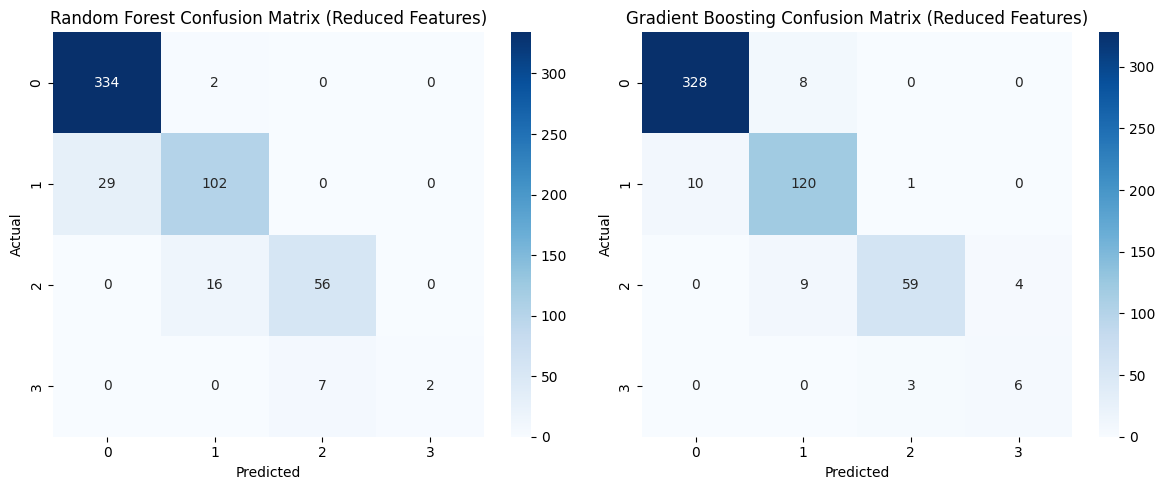

Random Forest Classification Report (Reduced Features):
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       336
         1.0       0.85      0.78      0.81       131
         2.0       0.89      0.78      0.83        72
         3.0       1.00      0.22      0.36         9

    accuracy                           0.90       548
   macro avg       0.91      0.69      0.74       548
weighted avg       0.90      0.90      0.90       548

Gradient Boosting Classification Report (Reduced Features):
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       336
         1.0       0.88      0.92      0.90       131
         2.0       0.94      0.82      0.87        72
         3.0       0.60      0.67      0.63         9

    accuracy                           0.94       548
   macro avg       0.85      0.84      0.84       548
weighted avg       0.94      0.94      0.94       548

Feature name

In [173]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Update the preprocessor to include an imputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')  # Use mean imputation for missing numerical values
scaler = StandardScaler()

# Updated ColumnTransformer with imputer and scaler for numerical features
updated_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numerical_imputer),
            ('scaler', scaler)
        ]), updated_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Preprocess the new datasets
X_train_preprocessed_reduced = updated_preprocessor.fit_transform(X_train_reduced)
X_test_preprocessed_reduced = updated_preprocessor.transform(X_test_reduced)

# Train the Random Forest and Gradient Boosting models on the updated dataset
rf_model_reduced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42)
gb_model_reduced = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Fit the models
rf_model_reduced.fit(X_train_preprocessed_reduced, y_train)
gb_model_reduced.fit(X_train_preprocessed_reduced, y_train)

# Generate predictions
rf_predictions_reduced = rf_model_reduced.predict(X_test_preprocessed_reduced)
gb_predictions_reduced = gb_model_reduced.predict(X_test_preprocessed_reduced)

# Confusion Matrices
rf_conf_matrix_reduced = confusion_matrix(y_test, rf_predictions_reduced)
gb_conf_matrix_reduced = confusion_matrix(y_test, gb_predictions_reduced)

# Plotting the Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix_reduced, annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix (Reduced Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(gb_conf_matrix_reduced, annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix (Reduced Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification Reports
rf_report_reduced = classification_report(y_test, rf_predictions_reduced)
gb_report_reduced = classification_report(y_test, gb_predictions_reduced)

print("Random Forest Classification Report (Reduced Features):\n", rf_report_reduced)
print("Gradient Boosting Classification Report (Reduced Features):\n", gb_report_reduced)

# Assessing Feature Importance for the new models
importances_rf_reduced = rf_model_reduced.feature_importances_
importances_gb_reduced = gb_model_reduced.feature_importances_

# Update feature names list by removing 'PCIAT-PCIAT_Total'
updated_feature_names = [name for name in all_feature_names if name != 'PCIAT-PCIAT_Total']

# Creating a DataFrame for feature importance
if len(updated_feature_names) == len(importances_rf_reduced):
    feature_importance_reduced_df = pd.DataFrame({
        'Feature': updated_feature_names,
        'RandomForest Importance': importances_rf_reduced,
        'GradientBoosting Importance': importances_gb_reduced
    })

    # Sorting the features by importance for RandomForest
    feature_importance_reduced_rf_sorted = feature_importance_reduced_df.sort_values(by='RandomForest Importance', ascending=False)

    # Plotting feature importance for RandomForest
    plt.figure(figsize=(10, 8))
    sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_reduced_rf_sorted.head(15))
    plt.title('Top 15 Feature Importances - Random Forest (Reduced Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Sorting the features by importance for Gradient Boosting
    feature_importance_reduced_gb_sorted = feature_importance_reduced_df.sort_values(by='GradientBoosting Importance', ascending=False)

    # Plotting feature importance for Gradient Boosting
    plt.figure(figsize=(10, 8))
    sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_reduced_gb_sorted.head(15))
    plt.title('Top 15 Feature Importances - Gradient Boosting (Reduced Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Feature names length and feature importances length do not match. Please verify the preprocessing step.")


Results Interpretation

Random Forest (Reduced Features):

    Accuracy: 90%

Class 3 Performance:

        Precision remains high, but recall is still low (0.22), indicating challenges in identifying instances of Class 3.

Other Classes:

        Class 0 maintains strong performance.
        Class 1 and Class 2 saw a decrease in performance, likely because PCIAT-PCIAT_Total previously helped in identifying these classes.

Gradient Boosting (Reduced Features):

Accuracy: 94%

Class 3 Performance:
        There is an improvement in recall for Class 3 (0.67), suggesting the model is doing better at identifying this minority class compared to the Random Forest model.

Other Classes:

        Class 1 and Class 2 show improved recall compared to the Random Forest model.
        The performance for Class 0 is still very high.

### Feature Extraction

Number of features after transformation: 2268
Number of feature names extracted: 2268


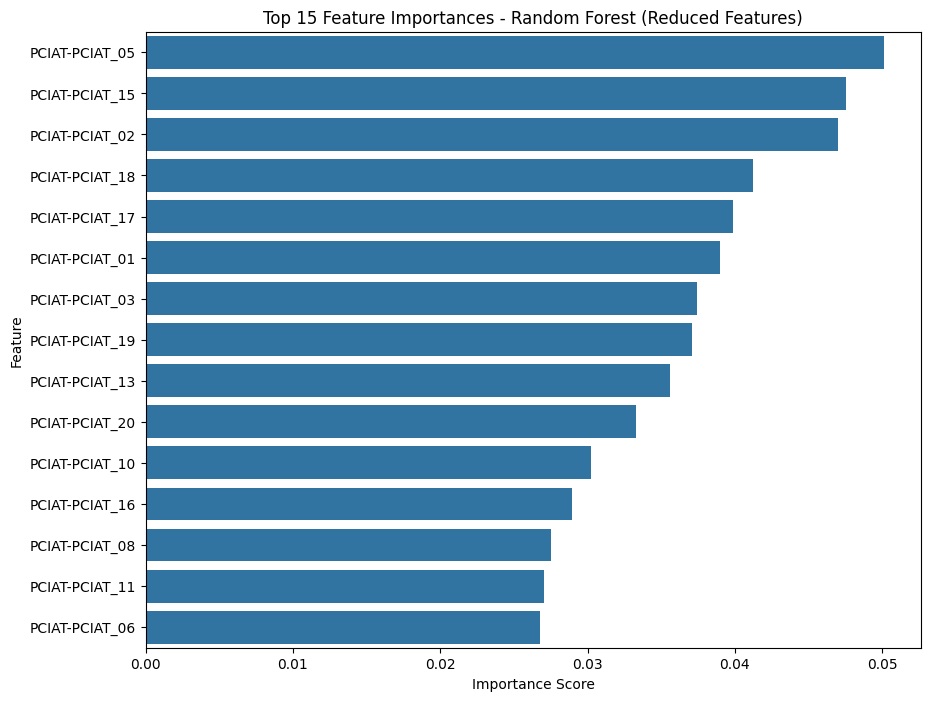

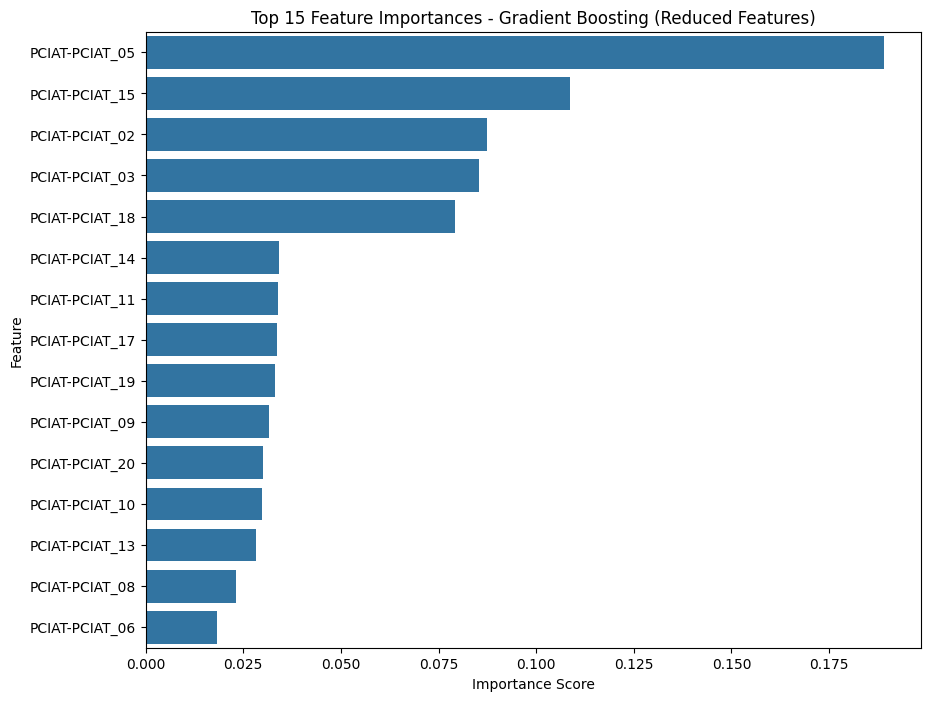

In [175]:
# Extracting feature names after preprocessing
def get_feature_names_from_column_transformer(ct):
    """Function to get the feature names from a ColumnTransformer"""
    output_features = []
    for name, transformer, columns in ct.transformers_:
        if name == 'num':
            # For numerical features (which used an imputer and scaler)
            output_features.extend(columns)
        elif name == 'cat':
            # For categorical features after one-hot encoding
            output_features.extend(
                transformer.get_feature_names_out(columns)
            )
    return output_features

# Get the transformed feature names
updated_feature_names = get_feature_names_from_column_transformer(updated_preprocessor)

# Verify the length of the updated feature names matches the number of features after transformation
n_transformed_features = X_train_preprocessed_reduced.shape[1]
print(f"Number of features after transformation: {n_transformed_features}")
print(f"Number of feature names extracted: {len(updated_feature_names)}")

# If they match, proceed with creating the feature importance DataFrame
if len(updated_feature_names) == len(importances_rf_reduced):
    feature_importance_reduced_df = pd.DataFrame({
        'Feature': updated_feature_names,
        'RandomForest Importance': importances_rf_reduced,
        'GradientBoosting Importance': importances_gb_reduced
    })

    # Sorting the features by importance for RandomForest
    feature_importance_reduced_rf_sorted = feature_importance_reduced_df.sort_values(by='RandomForest Importance', ascending=False)

    # Plotting feature importance for RandomForest
    plt.figure(figsize=(10, 8))
    sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_reduced_rf_sorted.head(15))
    plt.title('Top 15 Feature Importances - Random Forest (Reduced Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Sorting the features by importance for Gradient Boosting
    feature_importance_reduced_gb_sorted = feature_importance_reduced_df.sort_values(by='GradientBoosting Importance', ascending=False)

    # Plotting feature importance for Gradient Boosting
    plt.figure(figsize=(10, 8))
    sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_reduced_gb_sorted.head(15))
    plt.title('Top 15 Feature Importances - Gradient Boosting (Reduced Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print(f"Feature names length ({len(updated_feature_names)}) and feature importances length ({len(importances_rf_reduced)}) do not match. Please verify the preprocessing step.")


#### Insights

Removing PCIAT-PCIAT_Total led to a more balanced contribution from various individual questions, which could be beneficial for generalizability and avoiding over-reliance on a single metric.

Random Forest appears to have a more evenly distributed feature importance compared to Gradient Boosting, which still has a notable preference for a few key features.


### Creating Composite Features

Creating composite features by grouping related PCIAT questions into logical groups that represent distinct behavioral traits like compulsivity, escapism.

Compulsivity Composite: Combine related questions, e.g., PCIAT-PCIAT_01, PCIAT-PCIAT_05, etc.

Escapism Composite: Combine related questions, e.g., PCIAT-PCIAT_10, PCIAT-PCIAT_13, etc.

In [176]:
# Create new composite features from the existing PCIAT questions
X_train_combined['Compulsivity_Composite'] = X_train_combined[['PCIAT-PCIAT_01', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08']].sum(axis=1)
X_train_combined['Escapism_Composite'] = X_train_combined[['PCIAT-PCIAT_10', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_17']].sum(axis=1)

X_test_combined['Compulsivity_Composite'] = X_test_combined[['PCIAT-PCIAT_01', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08']].sum(axis=1)
X_test_combined['Escapism_Composite'] = X_test_combined[['PCIAT-PCIAT_10', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_17']].sum(axis=1)

# Drop individual features if composite features are used to prevent redundancy
X_train_combined.drop(columns=['PCIAT-PCIAT_01', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_17'], inplace=True)
X_test_combined.drop(columns=['PCIAT-PCIAT_01', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_17'], inplace=True)


In [179]:
# Identify categorical columns in your dataset
categorical_features = X_train_combined.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Features:", categorical_features)


Categorical Features: ['id']


In [180]:
# Update categorical features list
categorical_features = X_train_combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Update the ColumnTransformer to ensure all features are numeric before using SMOTE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), [feature for feature in X_train_combined.columns if feature not in categorical_features]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing to X_train_combined
X_train_preprocessed_combined = preprocessor.fit_transform(X_train_combined)

# Verify the output to ensure all values are numeric
print("Shape of preprocessed training data:", X_train_preprocessed_combined.shape)
print("Data type of preprocessed training data:", X_train_preprocessed_combined.dtype)


Shape of preprocessed training data: (2188, 2267)
Data type of preprocessed training data: float64


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed_combined, y_train)

# Split balanced data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)




Retraining Models with Composite Features and Balanced Data

Random Forest Classification Report (Balanced Data, Composite Features):
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       250
         1.0       0.99      0.99      0.99       259
         2.0       1.00      1.00      1.00       257
         3.0       1.00      1.00      1.00       241

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007

Gradient Boosting Classification Report (Balanced Data, Composite Features):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       250
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       257
         3.0       1.00      1.00      1.00       241

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00

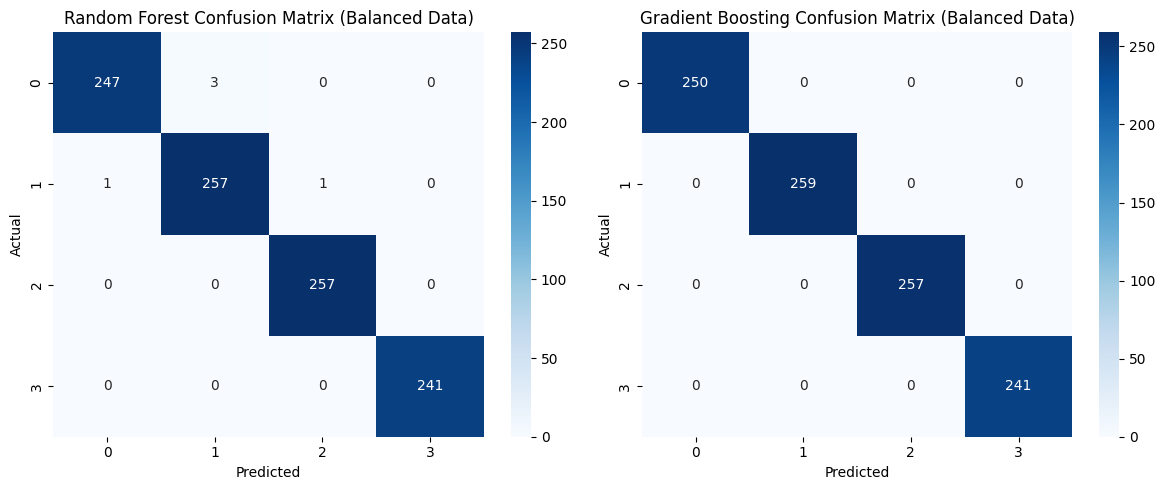

In [183]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Random Forest and Gradient Boosting models with the best hyperparameters from previous tuning
rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42)
gb_model_balanced = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Fit the Random Forest model
rf_model_balanced.fit(X_train_resampled, y_train_resampled)

# Fit the Gradient Boosting model
gb_model_balanced.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
rf_predictions_val = rf_model_balanced.predict(X_val_resampled)
gb_predictions_val = gb_model_balanced.predict(X_val_resampled)

# Evaluate the models using the validation set
print("Random Forest Classification Report (Balanced Data, Composite Features):\n", classification_report(y_val_resampled, rf_predictions_val))
print("Gradient Boosting Classification Report (Balanced Data, Composite Features):\n", classification_report(y_val_resampled, gb_predictions_val))

# Plot Confusion Matrices for Validation Set
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_val_resampled, rf_predictions_val), annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Gradient Boosting Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_val_resampled, gb_predictions_val), annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Training Models

Random Forest Classification Report (Balanced Data, Composite Features):
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       250
         1.0       0.99      0.99      0.99       259
         2.0       1.00      1.00      1.00       257
         3.0       1.00      1.00      1.00       241

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007

Gradient Boosting Classification Report (Balanced Data, Composite Features):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       250
         1.0       1.00      1.00      1.00       259
         2.0       1.00      1.00      1.00       257
         3.0       1.00      1.00      1.00       241

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00

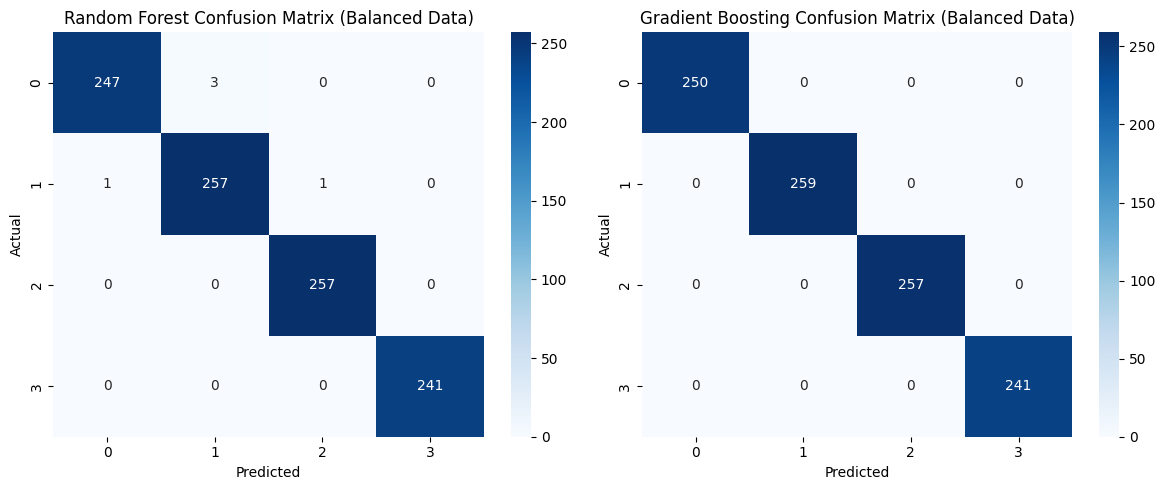

In [185]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Random Forest and Gradient Boosting models with the best hyperparameters from previous tuning
rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42)
gb_model_balanced = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Fit the Random Forest model
rf_model_balanced.fit(X_train_resampled, y_train_resampled)

# Fit the Gradient Boosting model
gb_model_balanced.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
rf_predictions_val = rf_model_balanced.predict(X_val_resampled)
gb_predictions_val = gb_model_balanced.predict(X_val_resampled)

# Evaluate the models using the validation set
print("Random Forest Classification Report (Balanced Data, Composite Features):\n", classification_report(y_val_resampled, rf_predictions_val))
print("Gradient Boosting Classification Report (Balanced Data, Composite Features):\n", classification_report(y_val_resampled, gb_predictions_val))

# Plot Confusion Matrices for Validation Set
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_val_resampled, rf_predictions_val), annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Gradient Boosting Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_val_resampled, gb_predictions_val), annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Model Evaluation on the Test Set

Random Forest Classification Report (Test Data, Balanced & Composite Features):
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       336
         1.0       0.98      0.95      0.97       131
         2.0       0.99      0.96      0.97        72
         3.0       1.00      0.89      0.94         9

    accuracy                           0.98       548
   macro avg       0.99      0.95      0.97       548
weighted avg       0.98      0.98      0.98       548

Gradient Boosting Classification Report (Test Data, Balanced & Composite Features):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       336
         1.0       1.00      1.00      1.00       131
         2.0       1.00      1.00      1.00        72
         3.0       1.00      1.00      1.00         9

    accuracy                           1.00       548
   macro avg       1.00      1.00      1.00       548
weighted avg       

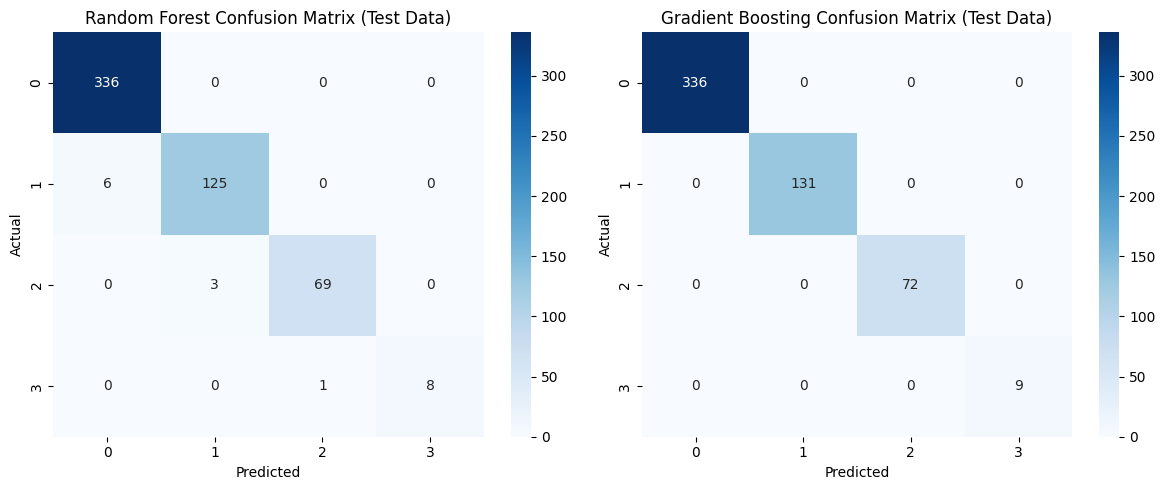

In [186]:
# Assuming X_test_combined has been preprocessed correctly using the same preprocessor
X_test_preprocessed_combined = preprocessor.transform(X_test_combined)

# Make predictions on the test set
rf_predictions_test = rf_model_balanced.predict(X_test_preprocessed_combined)
gb_predictions_test = gb_model_balanced.predict(X_test_preprocessed_combined)

# Print classification reports for the test set
print("Random Forest Classification Report (Test Data, Balanced & Composite Features):\n", classification_report(y_test, rf_predictions_test))
print("Gradient Boosting Classification Report (Test Data, Balanced & Composite Features):\n", classification_report(y_test, gb_predictions_test))

# Plot Confusion Matrices for Test Set
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix for Test Set
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_predictions_test), annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Gradient Boosting Confusion Matrix for Test Set
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, gb_predictions_test), annot=True, cmap='Blues', fmt='g')
plt.title('Gradient Boosting Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Feature Importance Analysis

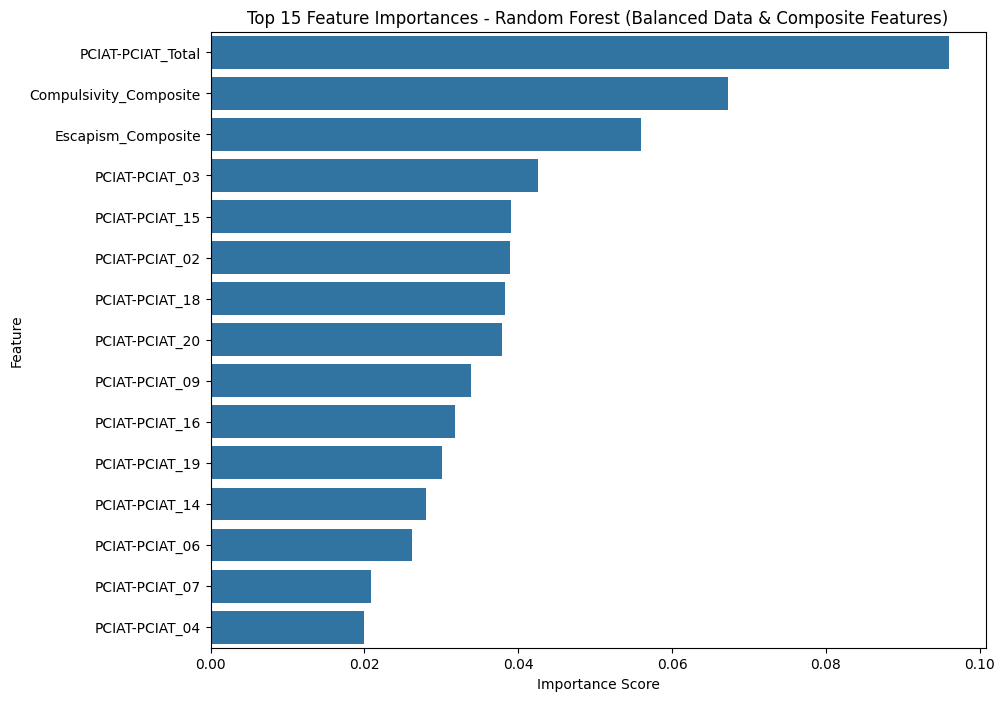

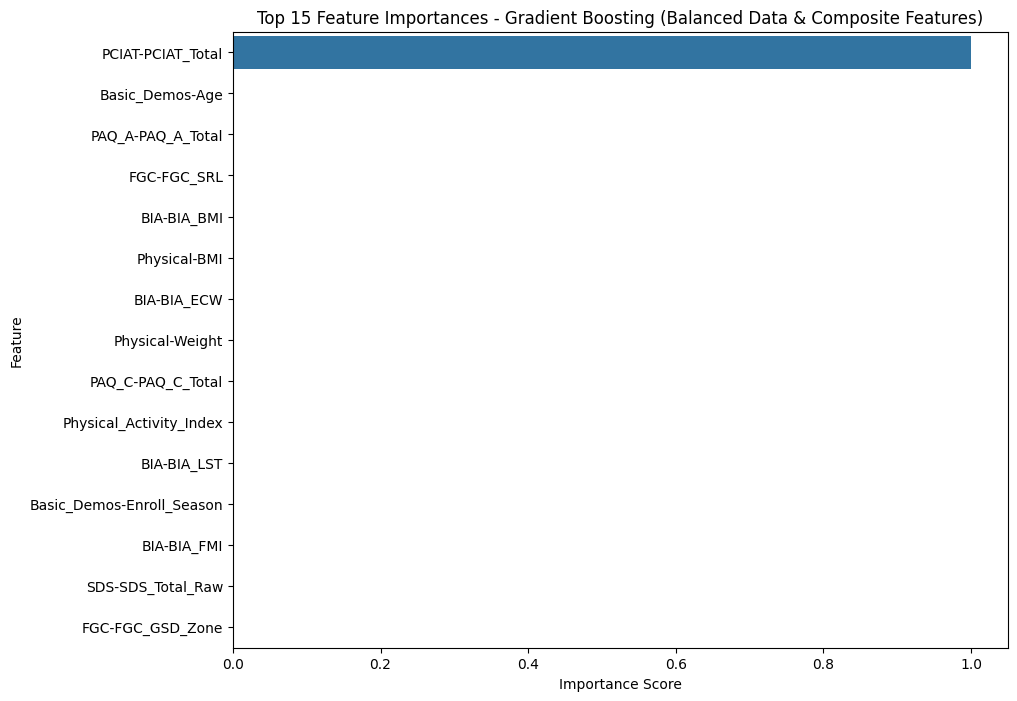

In [187]:
# Get feature importances from Random Forest and Gradient Boosting
importances_rf = rf_model_balanced.feature_importances_
importances_gb = gb_model_balanced.feature_importances_

# Get feature names after preprocessing (assuming preprocessor used correctly)
updated_feature_names = updated_numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Create DataFrame for feature importance
if len(updated_feature_names) == len(importances_rf):
    feature_importance_df = pd.DataFrame({
        'Feature': updated_feature_names,
        'RandomForest Importance': importances_rf,
        'GradientBoosting Importance': importances_gb
    })

    # Sort features by importance and plot
    feature_importance_rf_sorted = feature_importance_df.sort_values(by='RandomForest Importance', ascending=False)
    feature_importance_gb_sorted = feature_importance_df.sort_values(by='GradientBoosting Importance', ascending=False)

    # Plot Random Forest Feature Importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='RandomForest Importance', y='Feature', data=feature_importance_rf_sorted.head(15))
    plt.title('Top 15 Feature Importances - Random Forest (Balanced Data & Composite Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

    # Plot Gradient Boosting Feature Importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='GradientBoosting Importance', y='Feature', data=feature_importance_gb_sorted.head(15))
    plt.title('Top 15 Feature Importances - Gradient Boosting (Balanced Data & Composite Features)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
else:
    print(f"Feature names length and feature importances length do not match.")


In [194]:
# Assuming 'matched_column' is the name found in the previous step
matched_column = matching_columns[0]  # Update this if multiple similar columns exist

# Remove the matched column from the DataFrame
X_train_resampled_no_pciat = X_train_resampled_df.drop(columns=[matched_column])
X_val_resampled_no_pciat = X_val_resampled_df.drop(columns=[matched_column])
X_test_preprocessed_combined_no_pciat = X_test_preprocessed_combined_df.drop(columns=[matched_column])

# Optionally convert back to sparse matrices
from scipy.sparse import csr_matrix

X_train_resampled_no_pciat_sparse = csr_matrix(X_train_resampled_no_pciat)
X_val_resampled_no_pciat_sparse = csr_matrix(X_val_resampled_no_pciat)
X_test_preprocessed_combined_no_pciat_sparse = csr_matrix(X_test_preprocessed_combined_no_pciat)


Random Forest Classification Report (No PCIAT_Total):
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       250
         1.0       0.97      0.95      0.96       259
         2.0       0.99      1.00      0.99       257
         3.0       1.00      1.00      1.00       241

    accuracy                           0.98      1007
   macro avg       0.98      0.98      0.98      1007
weighted avg       0.98      0.98      0.98      1007

Gradient Boosting Classification Report (No PCIAT_Total):
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       250
         1.0       0.94      0.94      0.94       259
         2.0       0.98      0.99      0.98       257
         3.0       1.00      1.00      1.00       241

    accuracy                           0.97      1007
   macro avg       0.97      0.97      0.97      1007
weighted avg       0.97      0.97      0.97      1007



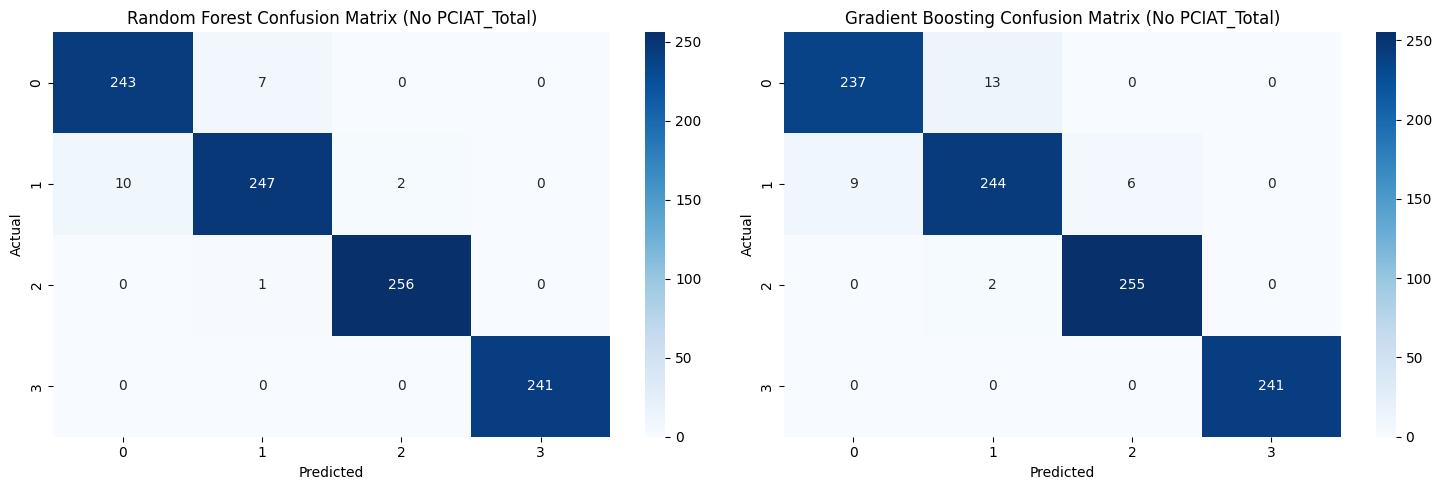

In [196]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initialize models
rf_model_no_pciat = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=10, min_samples_leaf=1, random_state=42)
gb_model_no_pciat = GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_depth=3, subsample=0.8, random_state=42)

# Fit the models with the new dataset (without 'PCIAT_Total')
rf_model_no_pciat.fit(X_train_resampled_no_pciat_sparse, y_train_resampled)
gb_model_no_pciat.fit(X_train_resampled_no_pciat_sparse, y_train_resampled)

# Validate the models
rf_predictions_no_pciat = rf_model_no_pciat.predict(X_val_resampled_no_pciat_sparse)
gb_predictions_no_pciat = gb_model_no_pciat.predict(X_val_resampled_no_pciat_sparse)

# Evaluate the models
from sklearn.metrics import classification_report, confusion_matrix

print("Random Forest Classification Report (No PCIAT_Total):")
print(classification_report(y_val_resampled, rf_predictions_no_pciat))

print("Gradient Boosting Classification Report (No PCIAT_Total):")
print(classification_report(y_val_resampled, gb_predictions_no_pciat))

# Confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_val_resampled, rf_predictions_no_pciat), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix (No PCIAT_Total)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Gradient Boosting Confusion Matrix
sns.heatmap(confusion_matrix(y_val_resampled, gb_predictions_no_pciat), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Gradient Boosting Confusion Matrix (No PCIAT_Total)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


## Children's Global Assessment Scale

In [ ]:
col_groups["CGAS"]

['CGAS-Season', 'CGAS-CGAS_Score', 'sii']

In [ ]:
data_dict[data_dict["Instrument"].str.contains("Children's Global")]

,Instrument,Field,Description,Type,Values,Value Labels
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN


Running a pair plot to check for any multicollinearity

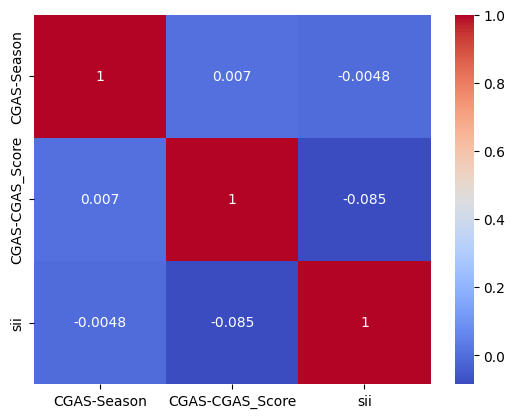

In [ ]:
# Assuming you have a dataframe 'df' with your features
correlation_matrix = data[col_groups["CGAS"]].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Drop rows where scores are empty 
# Dropping all because sometimes sii is empty too
CGAS_df = data[col_groups["CGAS"]].dropna()

### Multiclass Logistic Regression

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    CGAS_df.drop('sii', axis=1).to_numpy(),
    CGAS_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1405, 2)
y_train shape (1405, 1)
X_val shape (468, 2)
y_val shape (468, 1)
X_test shape (469, 2)
y_test shape (469, 1)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1]]),  # Define input layer
    tf.keras.layers.Dense(
        units=4,
        use_bias=False,
        activation='softmax',
        kernel_initializer='ones'
    )
])


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Build Model
model = build_model(model_type="multiclass", learning_rate=0.01, X_train=X_train)

# Get predictions for the current model (before training)
preds = model.predict(X_train)

# Do a single gradient update with model fitting
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=10,
    verbose=1  # This will display progress during training
)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]  # Loss after the first epoch
weights = model.layers[0].get_weights()[0].T  # Weights of the first layer (transpose for better visualization)

# Print predictions, loss, and weights
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)



44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0422 - val_loss: 1.4488
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1382 - val_loss: 1.2320
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0949 - val_loss: 1.0216
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0699 - val_loss: 1.2082
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0972 - val_loss: 1.0407
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0429 - val_loss: 0.9844
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0300 - val_loss: 0.9684
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0245 - val_loss: 0.9571
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0211 - val_loss: 0.9516
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0199 - val_loss: 0.9545
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0168 - val_loss: 0.9545
E

 Predictions:
 model is not learning from the data yet and is giving equal probabilities (since it's a multiclass classification problem with 4 classes)

 ***The learning rate or optimizer settings might need adjustment to enable faster learning.
 
Loss Before: 
model is not yet making good predictions, as it's still far from the optimal values
The weights for each feature are now both positive and negative, showing that the model is finding complex patterns.

Weights Before:
these weights should change to reflect learned patterns from the data
After: 
The weights for each feature are now both positive and negative, showing that the model is finding complex patterns.

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy is:0.5671641791044776
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9863 


0.9952205419540405

### Logistic Regression

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
CGAS_df['sii'] = CGAS_df['sii'].replace(2.0, 1.0)
CGAS_df['sii'] = CGAS_df['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
CGAS_df["sii"].value_counts()

sii
0.0    1359
1.0     983
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    CGAS_df.drop('sii', axis=1).to_numpy(),
    CGAS_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1405, 2)
y_train shape (1405, 1)
X_val shape (468, 2)
y_val shape (468, 1)
X_test shape (469, 2)
y_test shape (469, 1)


In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=2,                     # output dim
    input_shape=[X_train.shape[1]],             # input dim
    use_bias=False,              # we included the bias in X
    activation='sigmoid',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7376473546028137
W:
 [[1.0074618 1.0106976]
 [0.9925552 0.9893361]]


In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is: {accuracy}")
model.evaluate(x=X_test, y=y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy is: 0.5671641791044776
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8202 


0.8270957469940186

## Physical Measures

In [ ]:
col_groups["Physical"]

['Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'sii']

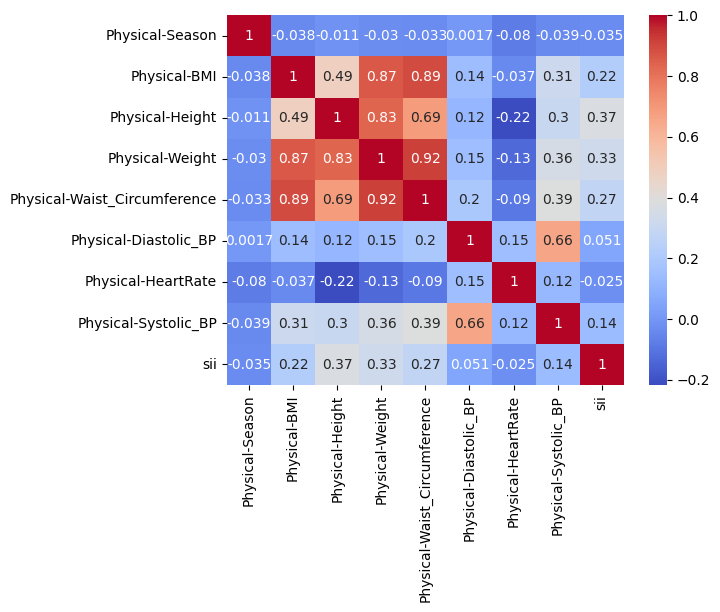

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = data[col_groups["Physical"]].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Droping height and weight as they correlate strongly with BMI. Diastolic and systolic correlate but they measure important different variables so keeping both.

In [ ]:
physical_df = data[col_groups["Physical"]]
physical_df.drop(['Physical-Height', 'Physical-Weight'], axis=1, inplace=True)

C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\3321936381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_df.drop(['Physical-Height', 'Physical-Weight'], axis=1, inplace=True)


In [ ]:
# Dropping all rows with empty values
physical_df = physical_df.dropna()

### Multiclass Regression

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [ ]:
def build_model(X_train, y_train, model_type="binary"):
    # Define your model-building logic based on the model_type
    if model_type == "multiclass":
        # Build a multiclass classification model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(y_train.shape[1], activation='softmax')  # Multiclass output
        ])
    else:
        # Handle binary classification or other models
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
        ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build Model
model = build_model(X_train=X_train, y_train=y_train, model_type="multiclass")

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


predictions:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
loss: 0.0
W:
 [[ 2.21584487e+00  1.93746102e+00  2.11778164e+00  2.02936101e+00
   2.47662616e+00  2.43168330e+00]
 [-9.11491662e-02  1.95281178e-01 -1.98049396e-01 -2.49996603e-01
   2.80879557e-01 -1.68860644e-01]
 [ 2.56545091e+00  2.03935909e+00  2.07651281e+00  2.49394202e+00
   2.62577391e+00  2.63905478e+00]
 [ 2.19408584e+00  2.35818911e+00  2.37180543e+00  2.40142441e+00
   2.13915777e+00  2.63930106e+00]
 [-7.76595026e-02 -1.58096477e-02 -3.01616937e-01 -1.89322084e-01
  -1.73604339e-02  1.05041571e-01]
 [-6.69972450e-02  1.52090549e-01  1.06860638e-01 -2.01421022e-01
  -7.55685568e-02 -1.30050480e-01]
 [ 2.63020247e-01  2.70191759e-01  9.93769914e-02 -1.04129575e-01
  -1.36186942e-01  4.59079668e-02]
 [-8.78638029e-02  1.06093258e-01  9.70484018e-02 -2.45953947e-01
   5.20799160e-02 -1.52872205e-02]
 [ 1.40199035e-01 -1.90142095e-02 -1.62924692e-01  8.16533267e-02
  -2.19967157e-01 -1.65103421e-01]
 [ 1.92307734e+00  2.10262

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy is:0.5638297872340425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2881 - loss: 0.0000e+00 


[0.0, 0.28723403811454773]

### Binary Regression

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
physical_df['sii'] = physical_df['sii'].replace(2.0, 1.0)
physical_df['sii'] = physical_df['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
physical_df["sii"].value_counts()

sii
0.0    303
1.0    161
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [ ]:
def build_binary_model(X_train, y_train):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build Binary Model
model = build_binary_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# Do a single gradient update
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1.        ]
 [1.        ]
 [1.        ]
 [0.99999994]
 [1.        ]
 [1.        ]]
loss: 4.273952007293701
W:
 [[ 1.09524012e-01 -2.23212481e-01  1.62324339e-01 -3.05721313e-01
   8.73546004e-02  4.56980765e-02]
 [-6.53407872e-02  4.51993942e-03 -2.31415555e-01 -3.45230103e-04
  -9.02287513e-02 -1.75496280e-01]
 [ 6.10664375e-02 -1.68280602e-01 -2.84213573e-01  8.70461091e-02
   5.19463047e-02  1.71577662e-01]
 [ 2.19026104e-01  1.52077004e-01 -1.72605768e-01  1.39365479e-01
   1.59151509e-01 -2.96167694e-02]
 [-8.45307112e-03 -1.68266699e-01  1.96000218e-01 -6.71921968e-02
  -1.56161949e-01 -1.34543911e-01]
 [ 2.20525503e-01 -1.96279228e-01 -2.44464651e-01 -9.48810354e-02
   2.60699153e-01  2.44751558e-01]
 [ 2.87397385e-01 -5.04001230e-02 -2.30017290e-01 -8.07498097e-02
  -2.76000768e-01  1.00595504e-01]
 [-1.32750005e-01 -1.19874716e-01 -9.15460885e-02 -2.32297763e-01
   1.50813371e-01  2.12892830e-01]
 [ 1.48404375e-01  1.69067636e-01  9.16321948e-02 -2.18032509e-01

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy is:0.5638297872340425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5752 - loss: 0.6893 


[0.6892167925834656, 0.5957446694374084]

## Fitness Endurance

In [ ]:
fitness_endurance_df = data[col_groups["Fitness_Endurance"]]

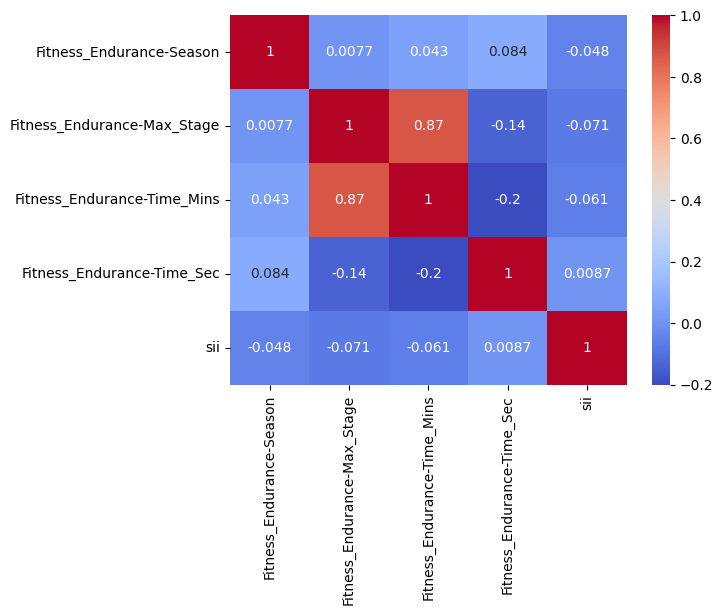

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = fitness_endurance_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Don't see any concerning correlation between dependant variables.

In [ ]:
# Dropping all rows with empty values
fitness_endurance_df = fitness_endurance_df.dropna()

### Multiclass Regression

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fitness_endurance_df.drop('sii', axis=1).to_numpy(),
    fitness_endurance_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (436, 4)
y_train shape (436, 1)
X_val shape (145, 4)
y_val shape (145, 1)
X_test shape (146, 4)
y_test shape (146, 1)


In [ ]:
def build_multiclass_model(X_train, y_train):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')  # Multiclass output
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build Multiclass Model
model = build_multiclass_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# Do a single gradient update
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


predictions:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
loss: 0.0
W:
 [[ 3.0396428   2.8672864   3.0960445   3.244557  ]
 [ 2.5760953   3.2503579   3.0214267   3.1889045 ]
 [-0.11714388 -0.1369163  -0.28599778 -0.2624371 ]
 [ 0.14388174 -0.14663617 -0.09908918 -0.2911184 ]
 [ 2.553147    2.590988    2.9518762   3.0091648 ]
 [ 2.8090096   3.3335452   3.0558336   3.2398982 ]
 [-0.12462863  0.00851096  0.00729738 -0.06481331]
 [ 2.5722973   3.104499    3.0785332   3.2193503 ]
 [ 2.8095465   3.225495    3.2434182   2.97472   ]
 [ 2.921798    2.8765545   3.3718765   3.3218813 ]
 [ 2.6546419   2.8895457   3.2249467   3.0334172 ]
 [ 2.796303    3.0476165   3.1134624   2.7358868 ]
 [ 2.7956939   2.849994    2.9372787   2.7619126 ]
 [-0.15128791  0.11889299 -0.14313857 -0.06549026]
 [ 2.6937385   2.8061419   2.8680537   3.1095421 ]
 [ 2.5894394   2.997217    2.9869843   2.7825112 ]
 [ 2.9750028   2.814369    2.839823    2.943618  ]
 [-0.13262515 -0.28683883  0.17534612 -0.00553142]
 [ 2.9588678   2.

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy is:0.7191780821917808
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2156 - loss: 0.0000e+00 


[0.0, 0.2054794579744339]

### Binary

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
fitness_endurance_df['sii'] = fitness_endurance_df['sii'].replace(2.0, 1.0)
fitness_endurance_df['sii'] = fitness_endurance_df['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
fitness_endurance_df["sii"].value_counts()

sii
0.0    480
1.0    247
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [ ]:
# Build Binary Model
model = build_binary_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# single gradient update
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
loss: 12.603232383728027
W:
 [[ 0.1059595  -0.23732553  0.15424484 -0.12281302 -0.13290712 -0.14625065]
 [ 0.20580786  0.15365453  0.10743829  0.01049002 -0.15257946 -0.01992754]
 [-0.22652133 -0.2862221   0.11406709 -0.10287571  0.06939054  0.09206581]
 [ 0.1844448  -0.06614061  0.18031669 -0.28070924 -0.16727026  0.17237674]
 [-0.05404908 -0.0974071   0.24517377  0.15689373 -0.31575996  0.01253541]
 [-0.02934922 -0.20753653  0.15116447  0.04764542  0.02050818  0.0832742 ]
 [-0.12535366 -0.21087286 -0.0721349  -0.03451617  0.2593232  -0.0114353 ]
 [-0.14716958 -0.18434532  0.22985068 -0.01248057  0.21038601 -0.16551885]
 [-0.2672382  -0.14166097 -0.13560964  0.01592809 -0.26833868 -0.27532005]
 [ 0.02337956 -0.23361418 -0.08420178 -0.12817246 -0.18642089 -0.22788659]
 [-0.17764024 -0.2624457   0.16610375 -0.26309952  0.07479775 -0.14061108]
 [ 0.25139317  0.24487866 -0.1404388   0.07910445  0.03289491 -0.02763372]
 [ 0.05044904  0.148

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy is:0.5638297872340425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5923 - loss: 0.6806 


[0.6777642369270325, 0.6063829660415649]

## FitnessGram Child

In [ ]:
fg_df = data[col_groups["FGC"]]

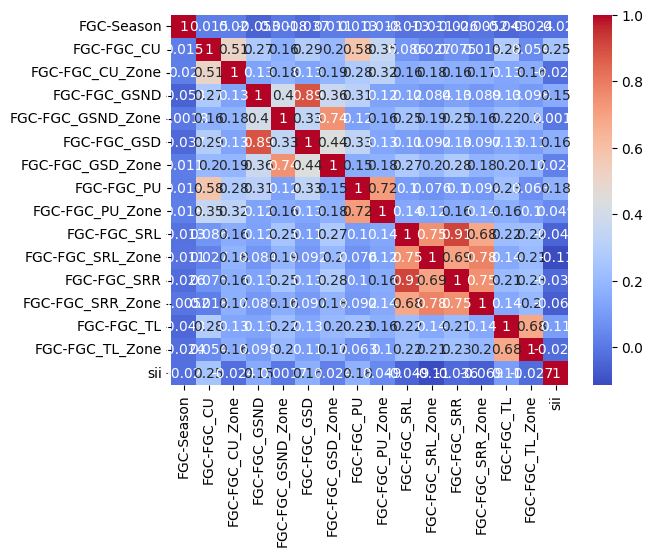

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = fg_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Looks like all the zones are just binned version of their equivalent fitness gram measurements.

In [ ]:
fg_df.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',"FGC-FGC_GSD_Zone",
            "FGC-FGC_PU_Zone","FGC-FGC_SRL_Zone","FGC-FGC_SRR_Zone",
            "FGC-FGC_TL_Zone"], axis=1, inplace=True)

C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\3364836189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fg_df.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',"FGC-FGC_GSD_Zone",


In [ ]:
# Dropping all rows with empty values
fg_df = fg_df.dropna()

### Multiclass

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [ ]:
# Build Multiclass Model
model = build_multiclass_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# Do a single gradient update
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


predictions:
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
loss: 0.0
W:
 [[-3.00625622e-01 -2.77098298e-01  1.25597017e-02  1.34889483e-01
   3.85930277e-02 -2.88942903e-01 -9.75247845e-02  2.12842766e-02]
 [ 1.83599079e+00  1.25779259e+00  1.28563511e+00  1.40600908e+00
   2.51072407e-01  1.50136268e+00  1.49080062e+00  1.93200791e+00]
 [ 1.77454174e+00  8.90005410e-01  9.39122140e-01  7.96119690e-01
   1.56682253e-01  1.57642627e+00  9.77194846e-01  1.49797821e+00]
 [ 1.48510623e+00  1.01268625e+00  1.18371403e+00  9.13483083e-01
   4.52093869e-01  1.81408191e+00  1.53082836e+00  1.94785023e+00]
 [ 1.83082581e+00  8.33534420e-01  1.35110164e+00  1.28623676e+00
   1.46996632e-01  1.83345449e+00  1.41294360e+00  1.95100296e+00]
 [-2.33252406e-01 -1.01059675e-01 -1.60101764e-02  8.83870199e-02
   3.53802919e-01 -1.90580517e-01 -1.42162189e-01 -2.95709550e-01]
 [ 1.61693668e+00  7.40171432e-01  1.27766001e+00  1.02384055e+00
  -3.29905339e-02  1.76811075e+00  1.33975756e+00  1.61390471e+00]
 [ 1

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The accuracy is:0.4046242774566474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3908 - loss: 0.0000e+00 


[0.0, 0.34682080149650574]

### Binary

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
fg_df['sii'] = fg_df['sii'].replace(2.0, 1.0)
fg_df['sii'] = fg_df['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
fg_df["sii"].value_counts()

sii
1.0    497
0.0    364
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [ ]:
# Build Binary Model
model = build_binary_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# Do a single gradient update
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.02395714]
 [0.02090356]
 [0.00019409]
 [0.12141176]
 [0.05758544]
 [0.00730639]]
loss: 1.0345162153244019
W:
 [[-0.16303094 -0.3100801  -0.03885749 -0.14805499 -0.07181352 -0.17411256
   0.07090221  0.29865947]
 [ 0.10445555  0.00753187  0.25046596 -0.09887852 -0.0811051   0.19572477
  -0.22870477 -0.38820037]
 [-0.21767014 -0.08565328  0.31035116 -0.11155173  0.00758021  0.00341087
  -0.2345577   0.13172747]
 [ 0.286143    0.2425621   0.26962304  0.15373445 -0.20635737  0.17442916
  -0.2286405  -0.09768496]
 [-0.04645599  0.2702324  -0.14162935  0.05824115 -0.05490319 -0.1700083
  -0.22641596  0.13953313]
 [-0.03266032  0.07581975 -0.00138199 -0.04517456 -0.35181665  0.10794648
   0.17648984  0.07274704]
 [ 0.24091758  0.11756766  0.13667561  0.12379327  0.10590171 -0.07588493
   0.02165726  0.29735824]
 [ 0.15254864  0.06053451 -0.2783133  -0.32297826  0.24710953 -0.07511419
  -0.01905318  0.1727346 ]
 [ 0.20703179 -0.05953297  0.16533093  0.11050719 -0.05635367  0.

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The accuracy is:0.4046242774566474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6443 - loss: 0.6325 


[0.6378358006477356, 0.6589595079421997]

## Bio-electric

 Since all the bio-electric impedance columns are missing, I suggest dropping them for now, especially if since we have other informative features (e.g., demographics, physical activity) that are already available. If these columns are critical later in the project, we can revisit them and explore imputation or other methods.
 Or we could use KNN imputation


In [ ]:
# List of bio-electric impedance columns to drop
bio_electric_columns = [
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_FFM', 
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
    'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'
]

# Drop the bio-electric impedance columns
data_cleaned = data.drop(columns=bio_electric_columns)

# Display the cleaned data to confirm the columns are removed
data_cleaned.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,3,5,0,0.0,51.0,3.0,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,3.0,3.0,2.0
1,000fd460,2,9,0,NaN,NaN,3.0,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,3.0,46.0,64.0,2.0,0.0,0.0
2,00105258,2,10,1,3.0,71.0,3.0,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,3.0,38.0,54.0,2.0,2.0,0.0
3,00115b9f,0,9,0,3.0,71.0,2.0,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,2.0,31.0,45.0,0.0,0.0,1.0
4,0016bb22,1,18,1,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check for missing values in the cleaned dataset
missing_data = data_cleaned.isnull().sum()
print(missing_data)


id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 68, dtype: int64


In [ ]:
bia_df = data[col_groups["BIA"]]

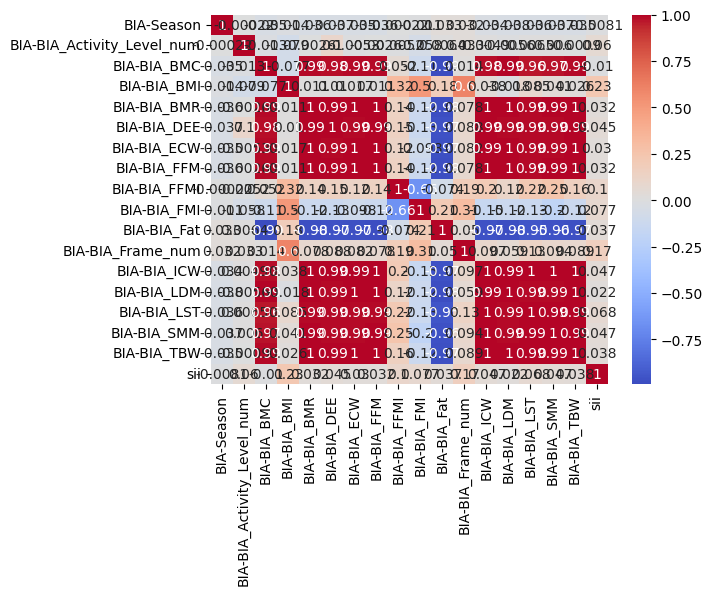

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = bia_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
data_dict[data_dict["Field"].str.contains("BIA")]

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


In [ ]:
bia_df['sii'] = bia_df['sii'].replace([2.0, 3.0], 1.0)  # 2 and 3 become 1 (e.g., unhealthy)
bia_df['sii'] = bia_df['sii'].replace(1.0, 0.0)  # 1 becomes 0 (e.g., healthy)

# Check if the replacement worked
bia_df["sii"].value_counts()


C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\3794810377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bia_df['sii'] = bia_df['sii'].replace([2.0, 3.0], 1.0)  # 2 and 3 become 1 (e.g., unhealthy)
C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\3794810377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bia_df['sii'] = bia_df['sii'].replace(1.0, 0.0)  # 1 becomes 0 (e.g., healthy)


sii
0.0    2736
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `bia_df` is your complete dataset and 'sii' is the target column
X = bia_df.drop(columns=['sii'])  # Features
y = bia_df['sii']                # Target variable

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert `X_val` and `y_val` to DataFrame/Series as needed for consistency
bia_val_df = X_val.copy()  # Optional: create a copy if you need a separate object


In [ ]:
# Clean NaN values in the dataset
bia_df = bia_df.dropna()  # Drop rows with NaN values

# Alternatively, replace NaN with default values (e.g., 0 or mean/median)
bia_df = bia_df.fillna(0)  # Example: replacing NaN with 0


In [ ]:
# Example: Keeping the validation features and adding the target for reference
bia_val_df['sii'] = y_val


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Handle NaN values first
bia_df = bia_df.dropna()

# Split into training and validation sets
X = bia_df.drop(columns=['sii'])  # Features
y = bia_df['sii']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ensure the target is integer
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# One-hot encode labels for multiclass classification (3 classes)
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)


In [ ]:
def build_bioimpedance_multiclass_model(X_train, y_train):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),  # First hidden layer
        tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')  # Multiclass output layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 units for 3 classes, softmax for multiclass
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)


C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9881 - loss: 0.8652 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.00

### Binary

### Multiclass

In [ ]:
# Build Multiclass Model for Bio-Electric Impedance
model = build_bioimpedance_multiclass_model(X_train, y_train)

# Get predictions for the current model
preds = model.predict(X_train)

# Train the model
history = model.fit(
  x=X_train,
  y=y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0
)

# Show the loss and new weights
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)


 1/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
predictions:
 [[7.9733822e-05 0.0000000e+00 9.9992025e-01]
 [3.2834476e-04 0.0000000e+00 9.9967170e-01]
 [1.9901348e-02 0.0000000e+00 9.8009872e-01]
 [1.5848269e-03 0.0000000e+00 9.9841511e-01]
 [8.6237240e-05 0.0000000e+00 9.9991381e-01]
 [2.9690838e-03 0.0000000e+00 9.9703085e-01]]
loss: 0.03518952429294586
W:
 [[ 0.02648325  0.16067989  0.07580487 ...  0.13463043 -0.1112863
   0.08749871]
 [ 0.16589181 -0.04944111 -0.18441573 ...  0.07136141 -0.13183776
   0.05837901]
 [-0.15978715  0.06172354  0.05065353 ... -0.12772533  0.14222328
   0.18005386]
 ...
 [ 0.16957982  0.03741975 -0.18062554 ...  0.08899607  0.19579329
   0.01931468]
 [ 0.11951387  0.08526617  0.03213145 ...  0.10747338 -0.01502803
   0.10656564]
 [-0.09620776  0.04997103 -0.14482799 ... -0.17337587 -0.14829415
  -0.05240256]]


In [ ]:
from tensorflow.keras.utils import to_categorical

# If labels are integers
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)


## Physical Activity

In [ ]:
paq_df = data[col_groups["PAQ"]]

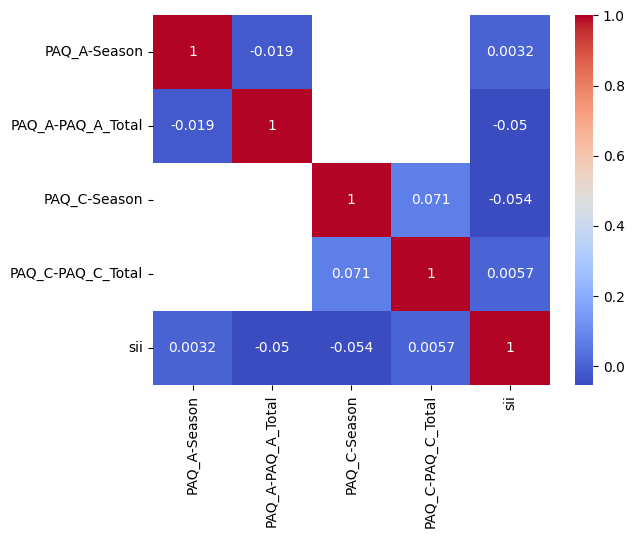

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = paq_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
paq_df

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,sii
0,NaN,NaN,NaN,NaN,2.0
1,NaN,NaN,3.0,2.340,0.0
2,NaN,NaN,2.0,2.170,0.0
3,NaN,NaN,0.0,2.451,1.0
4,2.0,1.04,NaN,NaN,NaN
...,...,...,...,...,...
3955,NaN,NaN,0.0,3.260,1.0
3956,NaN,NaN,0.0,2.340,NaN
3957,NaN,NaN,0.0,2.729,1.0
3958,NaN,NaN,1.0,3.300,0.0


In [ ]:
# Dropping all rows with empty values
paq_df = paq_df.dropna()

In [ ]:
paq_df

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,sii
3331,2.0,2.27,1.0,2.32,1.0


In [ ]:
data_dict[data_dict["Field"].str.contains("PAQ")]

,Instrument,Field,Description,Type,Values,Value Labels
50,Physical Activity Questionnaire (Adolescents),PAQ_A-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
51,Physical Activity Questionnaire (Adolescents),PAQ_A-PAQ_A_Total,Activity Summary Score (Adolescents),float,NaN,NaN
52,Physical Activity Questionnaire (Children),PAQ_C-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
53,Physical Activity Questionnaire (Children),PAQ_C-PAQ_C_Total,Activity Summary Score (Children),float,NaN,NaN


In [ ]:
# Check how many missing values there are in the target column ('sii')
missing_target_values = data_cleaned['sii'].isnull().sum()
print(f"Number of missing values in the target column ('sii'): {missing_target_values}")


Number of missing values in the target column ('sii'): 1224


In [ ]:
# Impute missing target values with the mode (most frequent value)
mode_value = data_cleaned['sii'].mode()[0]
data_cleaned['sii'] = data_cleaned['sii'].fillna(mode_value)

# Verify the number of remaining missing target values
missing_target_values = data_cleaned['sii'].isnull().sum()
print(f"Number of missing values in the target column after imputation: {missing_target_values}")


Number of missing values in the target column after imputation: 0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Prepare the features and target for classification
X = data_cleaned[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']]
y = data_cleaned['sii']

# Fill missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier with class weights
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Random Forest Classification Report:")
print(report)


C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\2486201832.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Random Forest Accuracy: 0.5657
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74       560
         1.0       0.26      0.26      0.26       148
         2.0       0.14      0.21      0.17        76
         3.0       0.04      0.12      0.06         8

    accuracy                           0.57       792
   macro avg       0.30      0.32      0.31       792
weighted avg       0.61      0.57      0.59       792



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Prepare the features and target for classification
X = data_cleaned[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']]
y = data_cleaned['sii']

# Fill missing values
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest model with class weights
rf_model_resampled = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
rf_model_resampled.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred_resampled = rf_model_resampled.predict(X_test)

# Evaluate the Random Forest model with resampling
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
report_resampled = classification_report(y_test, y_pred_resampled)
print(f"Random Forest Accuracy (with SMOTE): {accuracy_resampled:.4f}")
print("Random Forest Classification Report (with SMOTE):")
print(report_resampled)


C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\1385397730.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Random Forest Accuracy (with SMOTE): 0.5884
Random Forest Classification Report (with SMOTE):
              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76       560
         1.0       0.24      0.21      0.22       148
         2.0       0.15      0.16      0.15        76
         3.0       0.07      0.25      0.11         8

    accuracy                           0.59       792
   macro avg       0.30      0.34      0.31       792
weighted avg       0.60      0.59      0.59       792



# Binary

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Prepare the features and target for binary classification
X = data_cleaned[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']]  # Features
y = (data_cleaned['sii'] > 0).astype(int)  # Binary target (0 vs 1)

# Fill missing values in features and target
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network model for binary classification
model_binary = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_binary.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_binary = model_binary.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the model
y_pred_binary = model_binary.predict(X_test_scaled)
y_pred_binary = (y_pred_binary > 0.5).astype(int)  # Convert to binary (0 or 1)

# Evaluate the model
accuracy_binary = accuracy_score(y_test, y_pred_binary)
report_binary = classification_report(y_test, y_pred_binary)
print(f"Binary Neural Network Accuracy: {accuracy_binary:.4f}")
print("Binary Neural Network Classification Report:")
print(report_binary)


Epoch 1/50


C:\Users\Averine\AppData\Local\Temp\ipykernel_15164\95046971.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6744 - loss: 0.6500 - val_accuracy: 0.6932 - val_loss: 0.5875
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7005 - loss: 0.5802 - val_accuracy: 0.6944 - val_loss: 0.5851
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7006 - loss: 0.5778 - val_accuracy: 0.7008 - val_loss: 0.5820
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6994 - loss: 0.5760 - val_accuracy: 0.7020 - val_loss: 0.5801
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 0.5745 - val_accuracy: 0.6995 - val_loss: 0.5784
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6992 - loss: 0.5734 - val_accuracy: 0.6982 - val_loss: 0.5772
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7000 - loss: 0.5723 - val_accuracy: 0.6982 - val_loss: 0.5762
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7015 - loss: 0.5713 - val_accuracy: 0.6982 - val_

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classi

Notes: 

High Accuracy: This is likely skewed by the model's ability to predict the majority class effectively.

Low Macro Average Scores: Indicative of poor performance on at least one of the classes, usually the minority class.


### Multiclass

In [ ]:
X_multiclass = X_multiclass.copy()  # Make a copy of the DataFrame before modifying it
X_multiclass.fillna(X_multiclass.mean(), inplace=True)


NameError: name 'X_multiclass' is not defined

In [ ]:
# Prepare the features and target for multiclass classification
X_multiclass = data_cleaned[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']]  # Features
y_multiclass = data_cleaned['sii']  # Multiclass target (e.g., 0, 1, 2, 3)

# Fill missing values in features and target
X_multiclass.fillna(X_multiclass.mean(), inplace=True)
y_multiclass.fillna(y_multiclass.mode()[0], inplace=True)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_multiclass, y_multiclass, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network model for multiclass classification
model_multiclass = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(4, activation='softmax')  # Output layer for multiclass classification (4 classes)
])

# Compile the model
model_multiclass.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_multiclass = model_multiclass.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the model
y_pred_multiclass = model_multiclass.predict(X_test_scaled)
y_pred_multiclass = y_pred_multiclass.argmax(axis=1)  # Get class with the highest probability

# Evaluate the model
accuracy_multiclass = accuracy_score(y_test, y_pred_multiclass)
report_multiclass = classification_report(y_test, y_pred_multiclass)
print(f"Multiclass Neural Network Accuracy: {accuracy_multiclass:.4f}")
print("Multiclass Neural Network Classification Report:")
print(report_multiclass)


Epoch 1/50


C:\Users\Averine\AppData\Local\Temp\ipykernel_15032\1689804373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_multiclass.fillna(X_multiclass.mean(), inplace=True)
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 1.0686 - val_accuracy: 0.7045 - val_loss: 0.8158
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7008 - loss: 0.8049 - val_accuracy: 0.7033 - val_loss: 0.8131
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7015 - loss: 0.8018 - val_accuracy: 0.7045 - val_loss: 0.8100
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7015 - loss: 0.7995 - val_accuracy: 0.7058 - val_loss: 0.8093
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7036 - loss: 0.7981 - val_accuracy: 0.7071 - val_loss: 0.8082
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7038 - loss: 0.7968 - val_accuracy: 0.7071 - val_loss: 0.8066
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7038 - loss: 0.7954 - val_accuracy: 0.7071 - val_loss: 0.8054
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7038 - loss: 0.7940 - val_accuracy: 0.7071 - val_

C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Averine\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classi

Notes


Similar Accuracy: Again, the model is good at predicting the majority class but struggles with the minority classes.

Extremely Low Macro Average Scores: Very low precision, recall, and f1-score for minority classes.

## Internet Addiction

In [ ]:
pciat = data[col_groups["PCIAT"]]

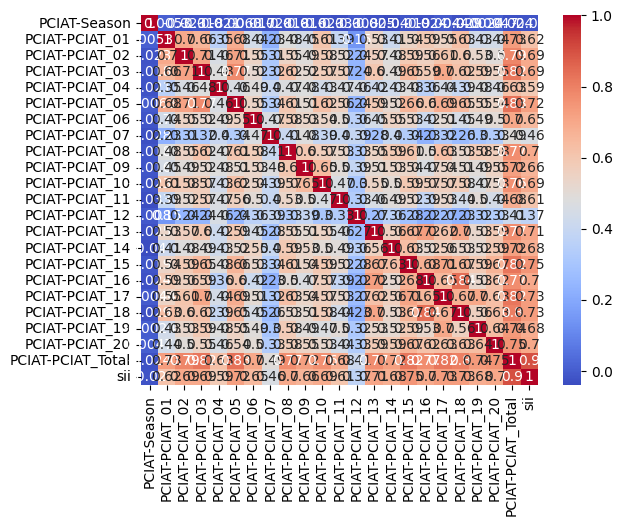

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = pciat.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Dropping PCIAT Total since that's the sum of all the PCIAT questions

In [ ]:
pciat.drop(['PCIAT-PCIAT_Total'], axis=1, inplace=True)

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3779530865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pciat.drop(['PCIAT-PCIAT_Total'], axis=1, inplace=True)


In [ ]:
# Dropping all rows with empty values
pciat = pciat.dropna()

### Multiclass

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    pciat.drop('sii', axis=1).to_numpy(),
    pciat[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1602, 21)
y_train shape (1602, 1)
X_val shape (534, 21)
y_val shape (534, 1)
X_test shape (535, 21)
y_test shape (535, 1)


In [ ]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.0213873386383057
W:
 [[ 1.9195477   1.4169095   0.9239212   1.7800341   0.50049114  1.064159
   0.7670871   0.8904111   0.5815955   0.7924638   0.6605463   1.1368132
   1.4826124   0.9078215   0.83717555  0.7206181   0.92412317  1.034521
   0.8732474   0.6238959   0.6898347 ]
 [ 0.9323412   0.99757177  1.1128551   1.2041734   0.7314455   1.2836285
   0.7676551   0.889097    0.8277505   0.98874986  0.7472521   1.1149255
   1.3156068   1.0269043   0.9315634   0.9750643   0.99688226  1.1251032
   0.9959852   0.81216973  0.8080144 ]
 [ 0.27294743  0.8449079   1.1037741   0.543706    1.2317476   1.065563
   0.9831643   0.9108749   1.0770826   1.0586079   1.2115455   1.009165
   0.7814402   1.1445795   1.040933    1.1318377   1.1501765   1.1832964
   1.2248702   1.1518459   0.90983295]
 [-0.43873426  0.45055243  0.78577787 -0.2918349

In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
The accuracy is:0.4300707485369901
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.0033


0.9710525870323181

### Binary

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
pciat['sii'] = pciat['sii'].replace(2.0, 1.0)
pciat['sii'] = pciat['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
pciat["sii"].value_counts()

sii
0.0    1568
1.0    1103
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [ ]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7593514919281006
W:
 [[1.0034976  0.98593074 0.99563515 0.98009896 0.9887276  1.0198101
  0.96487176 1.0005668 ]
 [0.99650496 1.0140725  1.0043653  1.0199004  1.0112742  0.9801899
  1.0351261  0.999435  ]]


In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


The accuracy is:0.4046242774566474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.8735


0.9018865823745728

## Sleep Disturbance

In [ ]:
sds = data[col_groups["SDS"]]

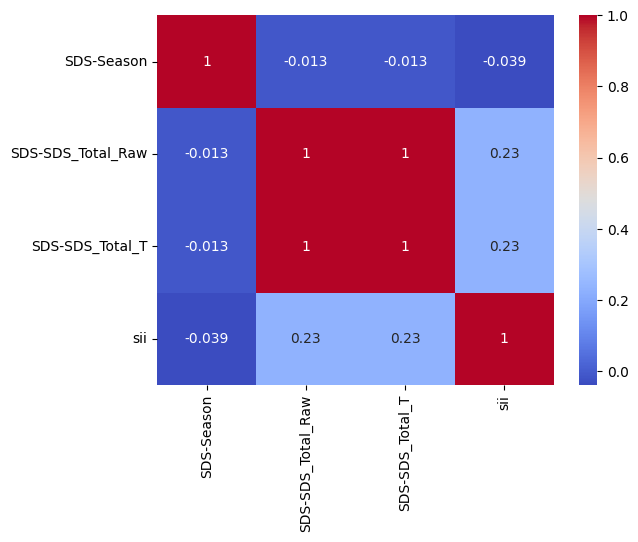

In [ ]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = sds.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Looks fine, nothing to worry about

In [ ]:
sds.drop(['SDS-SDS_Total_Raw'], axis=1, inplace=True)
# Dropping all rows with empty values
sds = sds.dropna()

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3251898247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sds.drop(['SDS-SDS_Total_Raw'], axis=1, inplace=True)


### Multiclass

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    sds.drop('sii', axis=1).to_numpy(),
    sds[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1515, 2)
y_train shape (1515, 1)
X_val shape (505, 2)
y_val shape (505, 1)
X_test shape (505, 2)
y_test shape (505, 1)


In [ ]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.1350101232528687
W:
 [[1.1507767  1.0263224 ]
 [0.99671763 1.0093713 ]
 [0.8348668  1.0042553 ]
 [0.7381782  0.9723876 ]]


In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
The accuracy is:0.5722772277227722
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 1.0772


1.0686020851135254

### Binary

In [ ]:
# Make sii a logistic regression to either refer or not refer a patient
sds['sii'] = sds['sii'].replace(2.0, 1.0)
sds['sii'] = sds['sii'].replace(3.0, 1.0)

In [ ]:
# Checking the replace worked
sds["sii"].value_counts()

sii
0.0    1470
1.0    1055
Name: count, dtype: int64

In [ ]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    sds.drop('sii', axis=1).to_numpy(),
    sds[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1515, 2)
y_train shape (1515, 1)
X_val shape (505, 2)
y_val shape (505, 1)
X_test shape (505, 2)
y_test shape (505, 1)


In [ ]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7174968123435974
W:
 [[1.0863172  1.0096649 ]
 [0.91367835 0.99033207]]


In [ ]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
The accuracy is:0.5722772277227722
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.8425


0.8394010663032532